<a href="https://colab.research.google.com/github/Vikim1000/Business-Case-Studies/blob/main/AdEase_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AdEase - Time Series

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

In [135]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [136]:
## Connecting to drive
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [137]:
# Reading dataset
df= pd.read_csv("/content/gdrive/MyDrive/Scaler Assignment/AdEase-Time_Series/train_1.csv")

In [138]:
# Reading Exogenous data
df_exog= pd.read_csv("/content/gdrive/MyDrive/Scaler Assignment/AdEase-Time_Series/Exog_Campaign_eng.csv")

- es - spanish
- zh-mandarin
- ru- russian
- de-German
- ja- Japanese
- fr-french
- en-english


In [139]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [140]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [141]:
df.shape

(145063, 551)

In [142]:
df_exog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Exog    550 non-null    int64
dtypes: int64(1)
memory usage: 4.4 KB


In [143]:
df_exog.shape

(550, 1)

In [144]:
df_exog.head()

,Exog
0,0
1,0
2,0
3,0
4,0


We have Exogenous Data for English only.

## Feature Engineering

We need to extract few informations from the page columns like 
- the page name, 
- the main domain, 
- the device type used to access the page, and also 
- the request origin(spider or browser agent)

In [145]:
#Feature Engineering to split the page, language
# Format-    SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN


In [146]:
# language 
# Define the regex pattern
pattern = '_([a-z]*).[a-z]+.org_'
df['language']= df['Page'].str.extract(pattern)

#Domain
# Define the regex pattern
pattern2 = '_[a-z]+.([a-z]+.org)_[a-z]+'
df['domain']= df['Page'].str.extract(pattern2)

#access_type
pattern3='_[a-z]*.[a-z]+.org_([a-z]+-[a-z]+|([a-z]+))_'
# Extract all matches using str.extract()
df['access_type']= df['Page'].str.extract(pattern3)[0]


#request_origin
pattern4= '(all-agents|spider)'
# Extract all matches using str.extract()
df['request_origin']= df['Page'].str.extract(pattern4)[0]

#page_name
pattern5= r'(.+(?=_[a-z]+.[a-z]+.org))'
# Extract all matches using str.extract()
df['page_name']=df['Page'].str.extract(pattern5)                                                                         

In [147]:
df.head(5)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,language,domain,access_type,request_origin,page_name
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,20.0,22.0,19.0,18.0,20.0,zh,wikipedia.org,all-access,spider,2NE1
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,30.0,52.0,45.0,26.0,20.0,zh,wikipedia.org,all-access,spider,2PM
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,6.0,3.0,4.0,17.0,zh,wikipedia.org,all-access,spider,3C
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,11.0,17.0,19.0,10.0,11.0,zh,wikipedia.org,all-access,spider,4minute
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,27.0,13.0,36.0,10.0,zh,wikipedia.org,all-access,spider,52_Hz_I_Love_You


In [148]:
## Rename the values in languages

df['language']=df['language'].replace(['en'],'english')
df['language']=df['language'].replace(['ja'],'Japanese')
df['language']=df['language'].replace(['de'],'German')
df['language']=df['language'].replace(['fr'],'french')
df['language']=df['language'].replace(['zh'],'mandarin')
df['language']=df['language'].replace(['ru'],'russian')
df['language']=df['language'].replace(['es'],'spanish')
languages= df['language'].value_counts().index.tolist()

In [149]:
# changing the language to others , for no language present columns
df['language']=df['language'].replace(['www'],'others')
ind= df.index[~df['language'].isin(languages)].tolist()
df=df.drop(ind)

In [150]:
# filling with zeros for null values 
df.fillna(0,inplace=True)

### Tranforming data to timseries input

In [151]:
ts= df.drop(columns=['Page','page_name','domain','access_type','request_origin'],axis=1)
ts.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,language
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,mandarin
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,mandarin
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,mandarin
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,mandarin
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,mandarin


### Languagewise timeseries data

In [152]:
ts=ts.groupby('language').sum().T
ts= ts.drop(columns=[''],axis=1)
ts.head()

language,German,Japanese,commons,english,french,mandarin,russian,spanish
2015-07-01,13260519.0,11863200.0,1140821.0,84712023.0,8458638.0,4144988.0,9463854.0,15278553.0
2015-07-02,13079896.0,13620792.0,1178130.0,84438316.0,8512952.0,4151189.0,9627643.0,14601013.0
2015-07-03,12554042.0,12305383.0,1150547.0,80167538.0,8186030.0,4123659.0,8923463.0,13427632.0
2015-07-04,11520379.0,15456239.0,951317.0,83463039.0,8749842.0,4163448.0,8393214.0,12606538.0
2015-07-05,13392347.0,14827204.0,1058036.0,86198403.0,8590493.0,4441286.0,8938528.0,13710356.0


In [153]:
ts.reset_index(inplace=True)
ts.rename(columns = {'index':'Date'}, inplace = True)
ts['Date'] = pd.to_datetime(ts['Date'])
ts.dtypes

language
Date        datetime64[ns]
German             float64
Japanese           float64
commons            float64
english            float64
french             float64
mandarin           float64
russian            float64
spanish            float64
dtype: object

In [154]:
ts.head()

language,Date,German,Japanese,commons,english,french,mandarin,russian,spanish
0,2015-07-01,13260519.0,11863200.0,1140821.0,84712023.0,8458638.0,4144988.0,9463854.0,15278553.0
1,2015-07-02,13079896.0,13620792.0,1178130.0,84438316.0,8512952.0,4151189.0,9627643.0,14601013.0
2,2015-07-03,12554042.0,12305383.0,1150547.0,80167538.0,8186030.0,4123659.0,8923463.0,13427632.0
3,2015-07-04,11520379.0,15456239.0,951317.0,83463039.0,8749842.0,4163448.0,8393214.0,12606538.0
4,2015-07-05,13392347.0,14827204.0,1058036.0,86198403.0,8590493.0,4441286.0,8938528.0,13710356.0


In [155]:
ts.set_index('Date', inplace=True)
ts.head()

language,German,Japanese,commons,english,french,mandarin,russian,spanish
Date,,,,,,,,
2015-07-01,13260519.0,11863200.0,1140821.0,84712023.0,8458638.0,4144988.0,9463854.0,15278553.0
2015-07-02,13079896.0,13620792.0,1178130.0,84438316.0,8512952.0,4151189.0,9627643.0,14601013.0
2015-07-03,12554042.0,12305383.0,1150547.0,80167538.0,8186030.0,4123659.0,8923463.0,13427632.0
2015-07-04,11520379.0,15456239.0,951317.0,83463039.0,8749842.0,4163448.0,8393214.0,12606538.0
2015-07-05,13392347.0,14827204.0,1058036.0,86198403.0,8590493.0,4441286.0,8938528.0,13710356.0


In [156]:
df['access_type'].value_counts()

all-access    70814
mobile-web    33836
desktop       33113
Name: access_type, dtype: int64

In [157]:
df['language'].value_counts()

english     24103
Japanese    20431
German      18546
french      17802
mandarin    17229
russian     15022
spanish     14069
commons     10555
                6
Name: language, dtype: int64

In [158]:
#df.iloc[82985,0]

In [159]:
df['domain'].value_counts()

wikipedia.org    127208
wikimedia.org     10555
Name: domain, dtype: int64

In [160]:
df['request_origin'].value_counts()

all-agents    104599
spider         33164
Name: request_origin, dtype: int64

In [161]:
df['page_name'].value_counts()

Special:Search                                                                                 31
Google                                                                                         30
Facebook                                                                                       28
YouTube                                                                                        28
IPhone                                                                                         24
                                                                                               ..
File:Anfield,_20_October_2012.jpg                                                               1
File:Animal_diversity.png                                                                       1
File:Anthonie_van_Leeuwenhoek_(1632-1723)._Natuurkundige_te_Delft_Rijksmuseum_SK-A-957.jpeg     1
File:Antonius_Kloster_BW_15_Retouched.jpg                                                       1
File:Shoes_in_teleph

## Exploratory Data Analysis

## Univariate Analysis

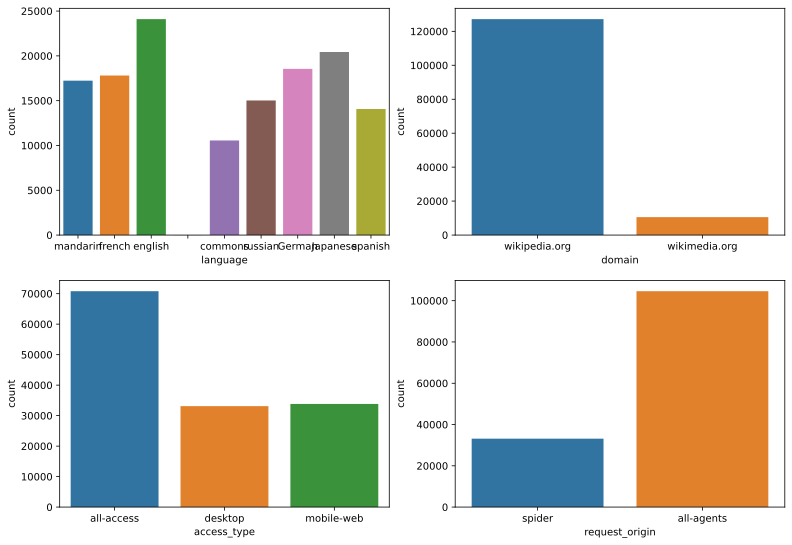

In [162]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(13, 9))
cat_cols=['language', 'domain', 'access_type', 'request_origin']
i = 0
for row in range(2):
    for col in range(2):
        sns.countplot(data=df, x=cat_cols[i], ax=axis[row, col])
        i += 1
        
plt.show()

- We can see, that the english language has huge count in dataset
- Also the Wikipedia.org domain has more in count than wikimedia.org
- And All-access access-type is more in count , and desktop, mobile-web has almost equal in numbers
- In Request_origin , All-agents is more than spider request_origin 

## Multivariate Analysis

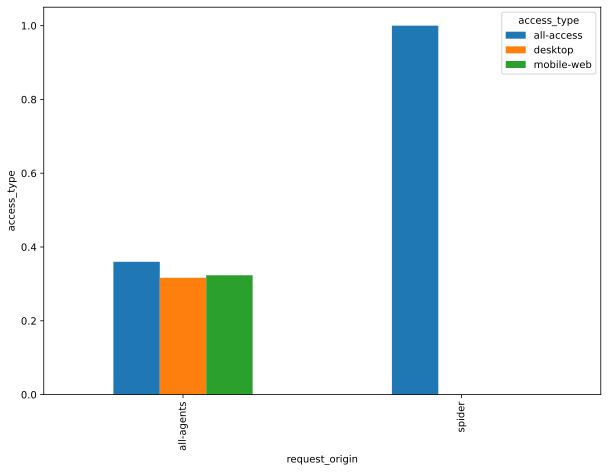

In [163]:

#Cross tab 
pd.crosstab(df['request_origin'],columns=df['access_type'], margins=True)
print()
print()
totalcount=pd.crosstab(df['request_origin'],columns=df['access_type'], normalize='index')
totalcount.plot(kind='bar',figsize=(10,7))
plt.xlabel("request_origin")
plt.ylabel("access_type")
plt.show()

We can see that , all-access type is more in spider , as well as all-agents request_origin

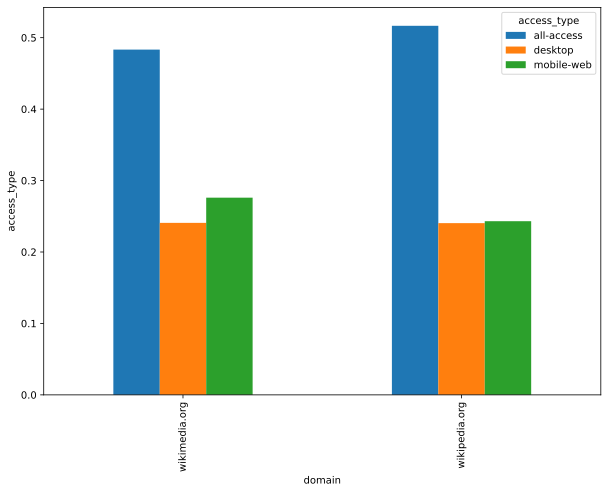

In [164]:

#Cross tab 
pd.crosstab(df['domain'],columns=df['access_type'], margins=True)
print()
print()
totalcount=pd.crosstab(df['domain'],columns=df['access_type'], normalize='index')
totalcount.plot(kind='bar',figsize=(10,7))
plt.xlabel("domain")
plt.ylabel("access_type")
plt.show()

We can clearly see , that the all-access accesstype is more in wikipedia and in wikimedia

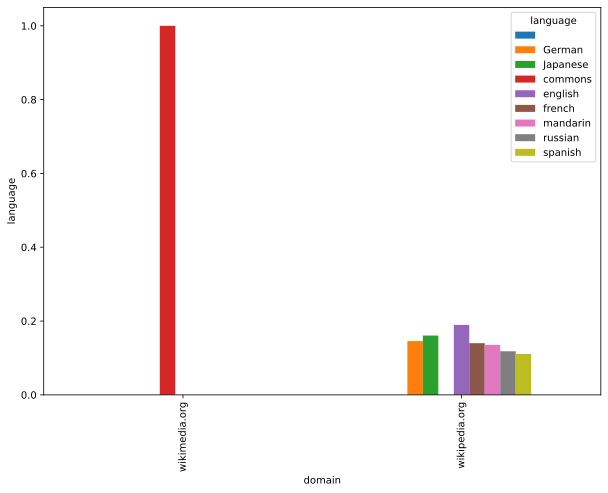

In [165]:

#Cross tab 
pd.crosstab(df['domain'],columns=df['language'], margins=True)
print()
print()
totalcount=pd.crosstab(df['domain'],columns=df['language'], normalize='index')
totalcount.plot(kind='bar',figsize=(10,7))
plt.xlabel("domain")
plt.ylabel("language")
plt.show()

- In Wikimedia, we can clearly see, that only Commons language is present, this tells that the wikimedia , might be a favourite source for commons 
- In Wikipedia, we can clearly see, english is high in count , and second highest is japanese

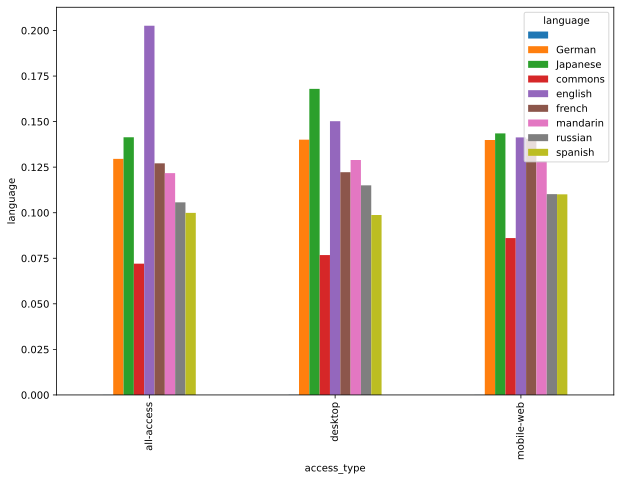

In [166]:

#Cross tab 
pd.crosstab(df['access_type'],columns=df['language'], margins=True)
print()
print()
totalcount=pd.crosstab(df['access_type'],columns=df['language'], normalize='index')
totalcount.plot(kind='bar',figsize=(10,7))
plt.xlabel("access_type")
plt.ylabel("language")
plt.show()

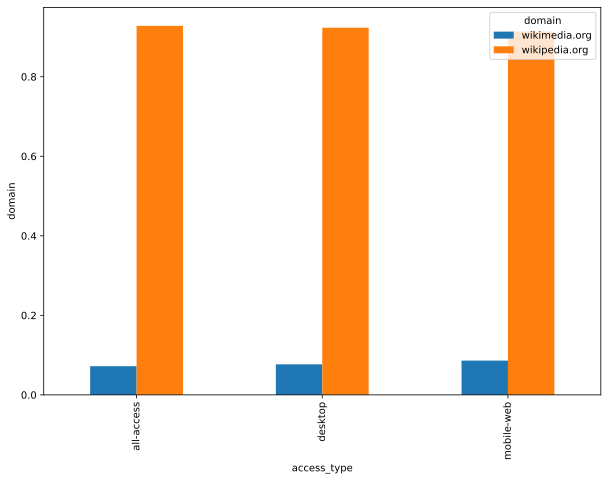

In [167]:

#Cross tab 
pd.crosstab(df['access_type'],columns=df['domain'], margins=True)
print()
print()
totalcount=pd.crosstab(df['access_type'],columns=df['domain'], normalize='index')
totalcount.plot(kind='bar',figsize=(10,7))
plt.xlabel("access_type")
plt.ylabel("domain")
plt.show()

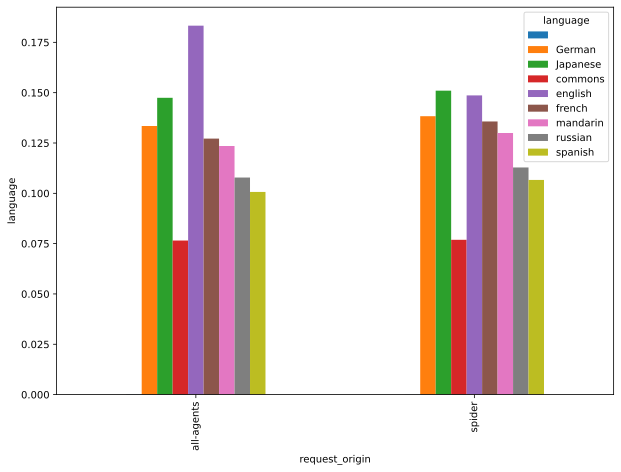

In [168]:

#Cross tab 
pd.crosstab(df['request_origin'],columns=df['language'], margins=True)
print()
print()
totalcount=pd.crosstab(df['request_origin'],columns=df['language'], normalize='index')
totalcount.plot(kind='bar',figsize=(10,7))
plt.xlabel("request_origin")
plt.ylabel("language")
plt.show()

# Model and Prediction

## Dickey-Fuller Test to Check Stationary

In [169]:
# Creating a function to test Dickey-Fuller test - to check data is stationary
plt.rcParams['figure.figsize'] = (20, 6)
def adf_test(data, significance_level=0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1] 
    if pvalue <= significance_level:
        print(s,':Sequence is stationary')
    else:
        print(s,':Sequence is not stationary')

In [170]:
languages

['english',
 'Japanese',
 'German',
 'french',
 'mandarin',
 'russian',
 'spanish',
 'commons',
 'www',
 '']

### Timeseries data PLOTTING

english :Sequence is not stationary
Japanese :Sequence is not stationary
German :Sequence is not stationary
french :Sequence is not stationary
mandarin :Sequence is not stationary
russian :Sequence is stationary
spanish :Sequence is stationary
commons :Sequence is not stationary


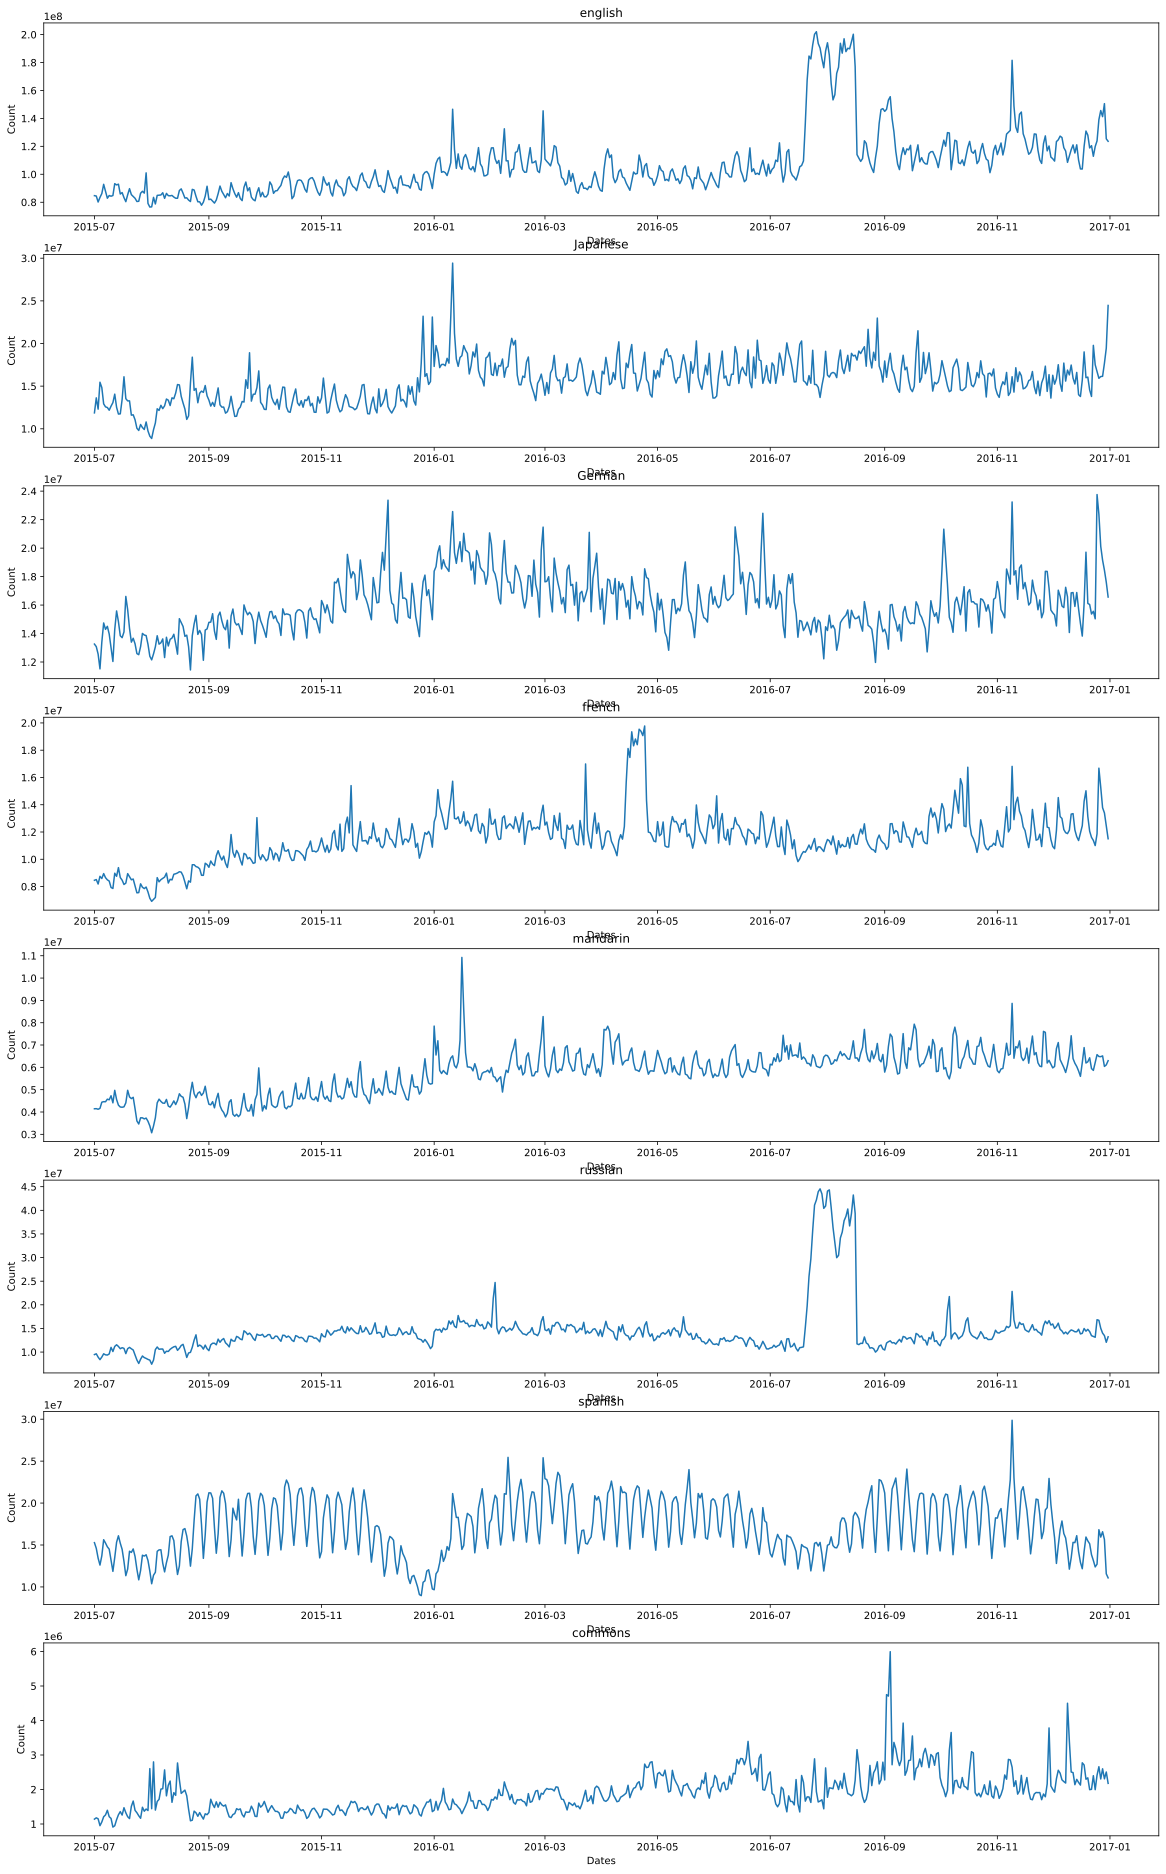

In [171]:
# Create a figure with 8 subplots in a column
fig, axs = plt.subplots(8, 1)
x=ts.index
for i in range(min(len(languages), 8)):
    s=languages[i]
    y=ts[s]
    axs[i].plot(x, y)
    axs[i].set(title=s, xlabel='Dates', ylabel='Count')
    adf_test(y)
# Adjust the spacing between subplots
plt.subplots_adjust(top=5,bottom=0.8)

We can see , russian and spanish are the only languages , that are stationary , so we use methods like decomposition and differencing to convert the timeseries data to stationary

## Converting Non Stationary to Stationary

1) Decomposition of series.

In [172]:
non_stationary=['english',
 'Japanese',
 'German',
 'french',
 'mandarin',
 'commons']

english :Sequence is stationary
Japanese :Sequence is stationary
German :Sequence is stationary
french :Sequence is stationary
mandarin :Sequence is stationary
commons :Sequence is stationary


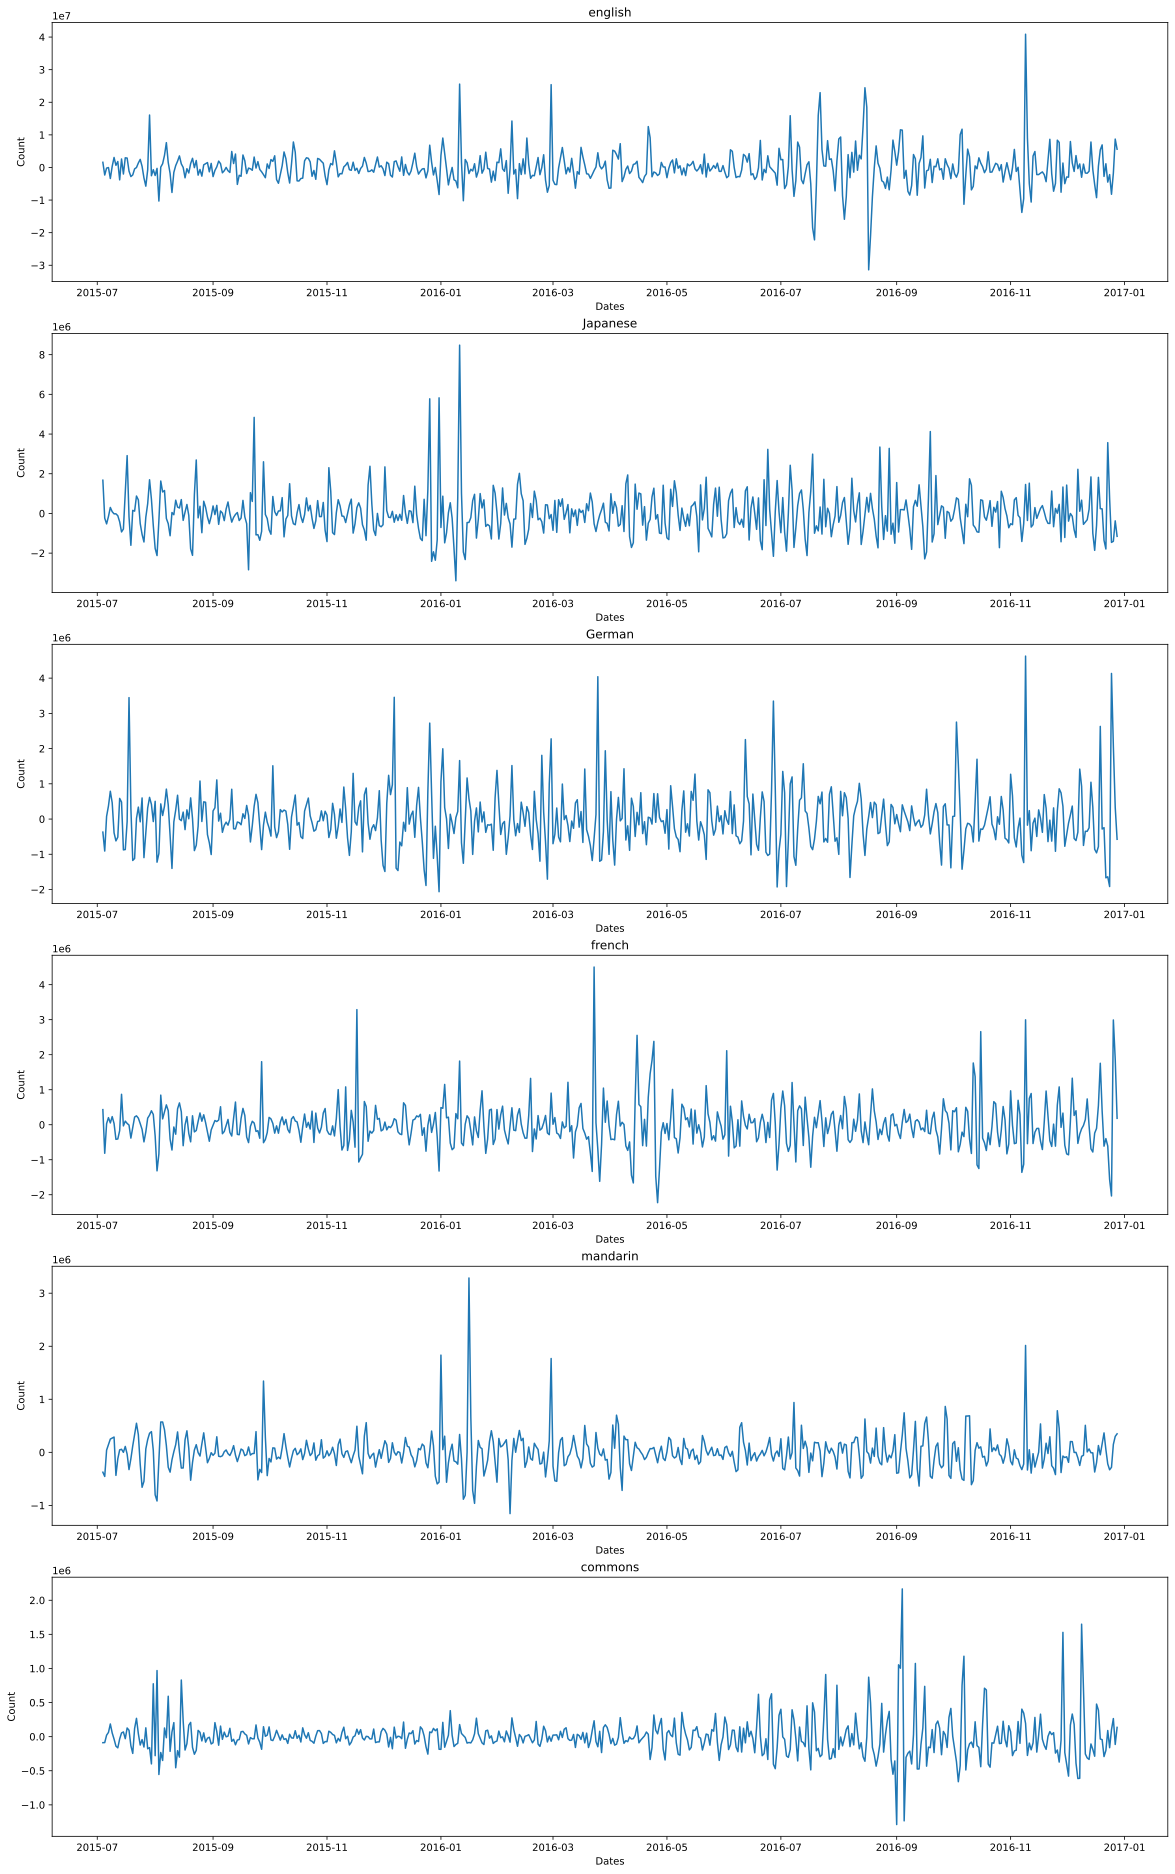

In [173]:
import statsmodels.api as sm

# Create a figure with 8 subplots in a column
fig, axs = plt.subplots(6, 1)
for i in range(min(len(non_stationary), 6)):
    s=non_stationary[i]
    data=ts[s]
    model = sm.tsa.seasonal_decompose(data, model='additive')
    x=model.resid.index
    y=model.resid
    axs[i].plot(x, y)
    axs[i].set(title=s, xlabel='Dates', ylabel='Count')
    adf_test(model.resid.dropna())
# Adjust the spacing between subplots
plt.subplots_adjust(top=5,bottom=0.8)

### Differencing

english :Sequence is stationary
Japanese :Sequence is stationary
German :Sequence is stationary
french :Sequence is stationary
mandarin :Sequence is stationary
commons :Sequence is stationary


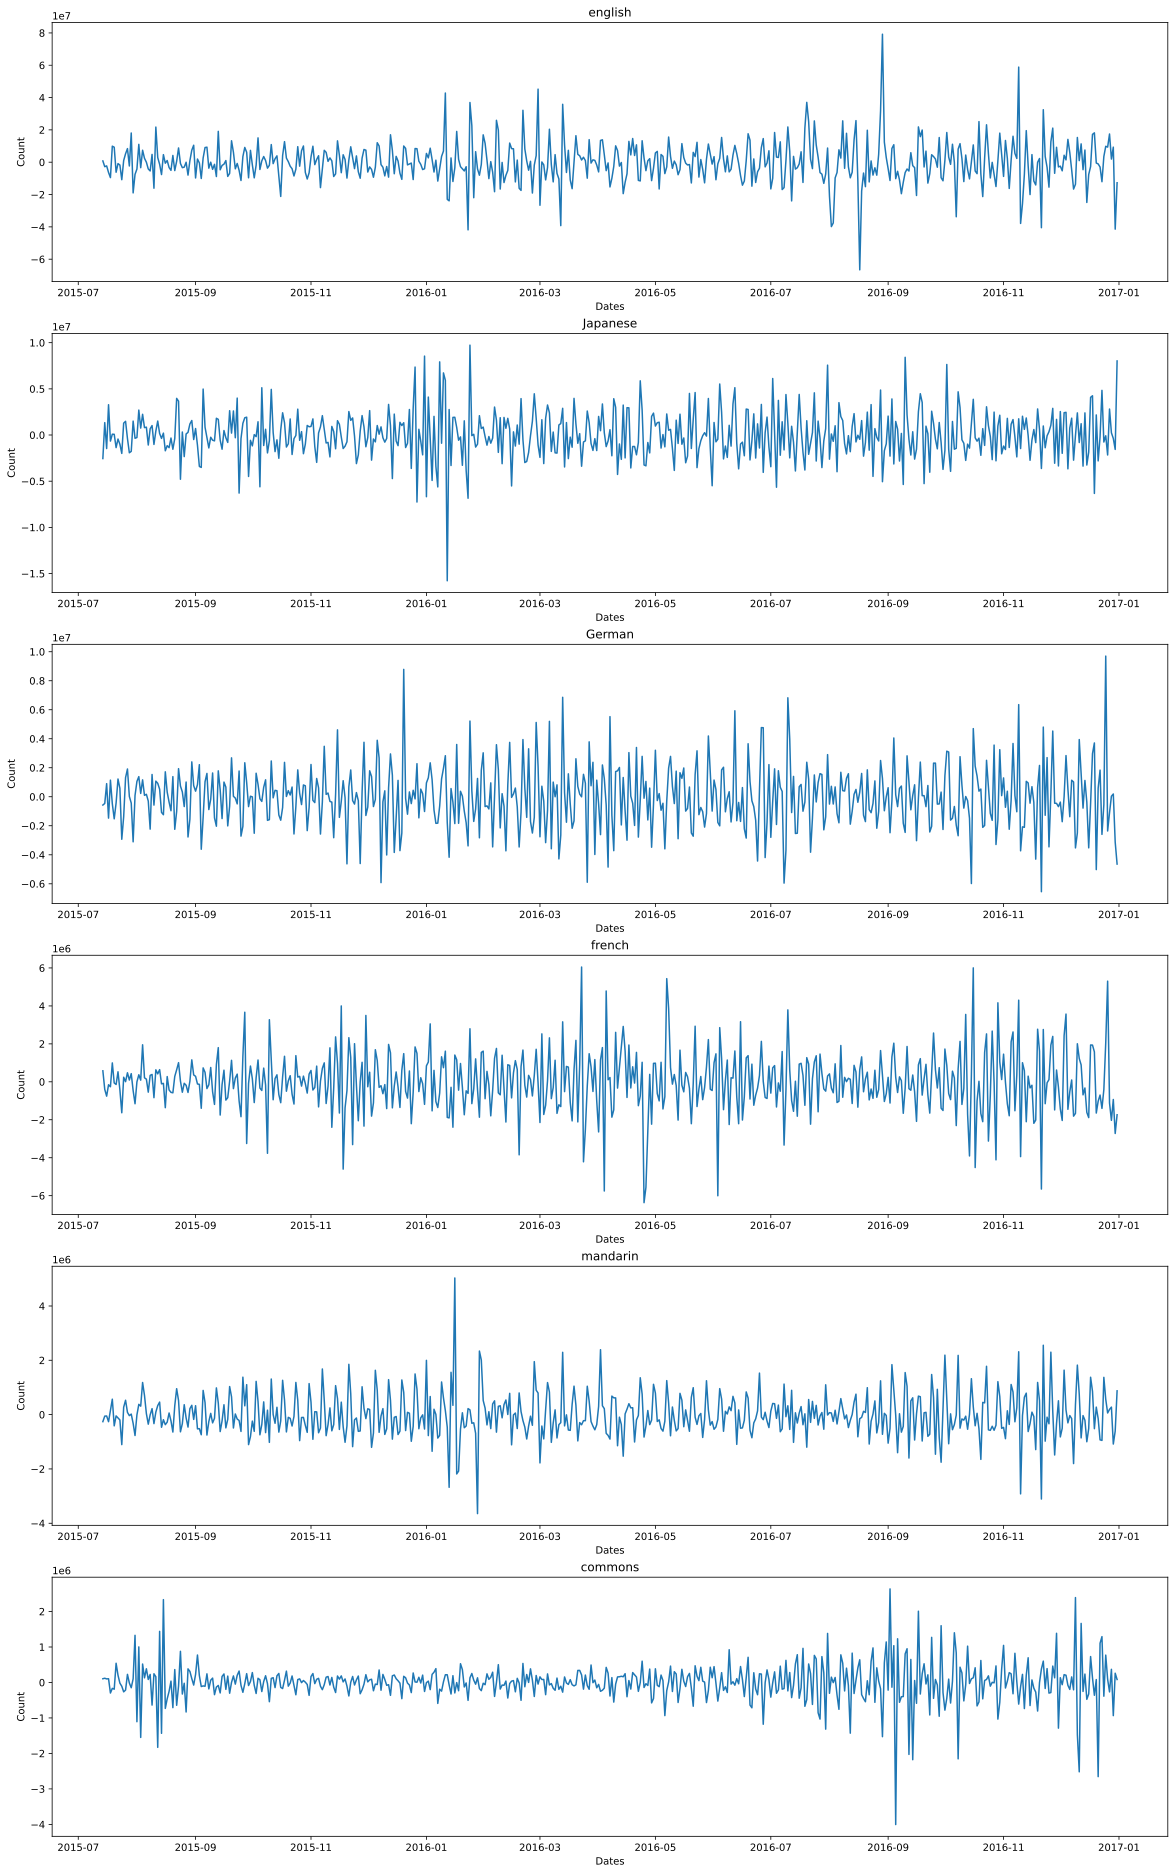

In [174]:
# no seasonality, no trend

# Create a figure with 6 subplots in a column
fig, axs = plt.subplots(6, 1)
for i in range(min(len(non_stationary), 6)):
    s=non_stationary[i]
    data=ts[s]
    x=data.diff(12).diff(1).index
    ts[f'stationary_{s}'] = data.diff(12).diff(1)
    y=data.diff(12).diff(1)
    axs[i].plot(x, y)
    axs[i].set(title=s, xlabel='Dates', ylabel='Count')
    adf_test(model.resid.dropna())
    
# Adjust the spacing between subplots
plt.subplots_adjust(top=5,bottom=0.8)

We can able to convert timeseries data in both decomposition and differencing , As we are going to use Arima, Sarimax we don't need stationary date

## Plotting the ACF and PACF plots

ACF (Auto-Correlation Function) measures the correlation between a time series and its lags. It is a plot of the correlation coefficient between the time series and its lags at different lag values. ACF is used to determine the number of lag terms to include in an AR (Auto Regressive) model. The ACF plot shows the strength of the correlation between the time series and its lags, with the correlation coefficient on the y-axis and the lag on the x-axis. If the ACF plot shows significant correlation for the first few lags and then decreases gradually to zero, it suggests that an AR model may be appropriate.

PACF (Partial Auto-Correlation Function) measures the correlation between a time series and its lags, after accounting for the correlation between the time series and the intervening lags. It is a plot of the correlation coefficient between the time series and its lags, adjusted for the effects of intervening lags. PACF is used to determine the number of lag terms to include in an MA (Moving Average) model. The PACF plot shows the strength of the correlation between the time series and its lags, with the correlation coefficient on the y-axis and the lag on the x-axis. If the PACF plot shows significant correlation for the first few lags and then decreases gradually to zero, it suggests that an MA model may be appropriate.

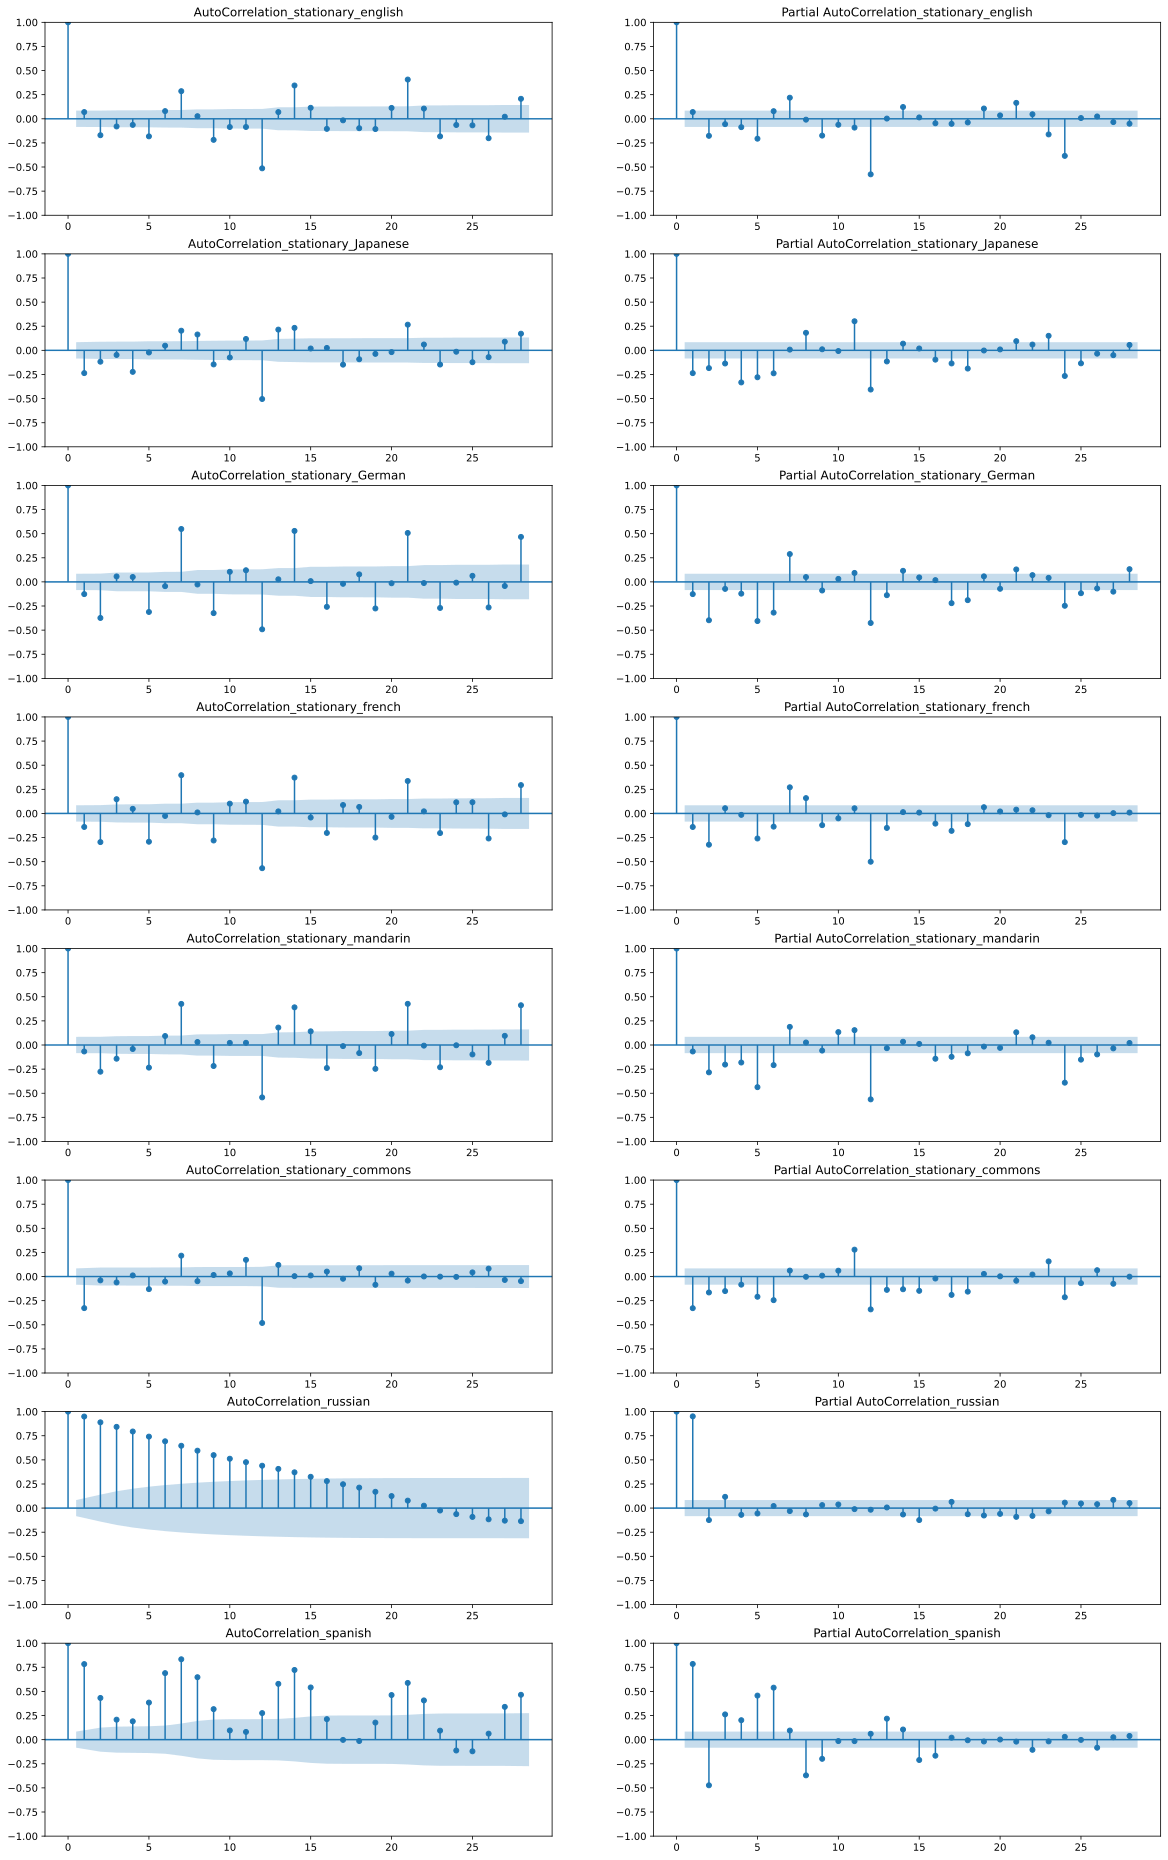

In [175]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plotting =['stationary_english', 'stationary_Japanese', 'stationary_German', 'stationary_french', 'stationary_mandarin', 'stationary_commons','russian','spanish']
# Create a figure with 8 subplots in a column
fig, ax = plt.subplots(8, 2)
for i in range(min(len(plotting), 8)):
    s=plotting[i]
    data=ts[s]
    plot_acf(data.dropna(), ax=ax[i,0],title=f'AutoCorrelation_{s}')
    plot_pacf(data.dropna(), ax=ax[i,1],title=f'Partial AutoCorrelation_{s}')  
    
    # Adjust the spacing between subplots
plt.subplots_adjust(top=5,bottom=0.8)

- We can see , that the ACF value starts decreasing from higher value to 0
- Similary WE can also see , PACF also decreases to 0 and going negative
- For Russia, commons, mandarian, french , japanese, ACF if high , and AR model will be best suitable

## Modelling

In [176]:
# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

In [177]:
#Making date as index in df_Exog dataframe
df_exog['Date']=ts.index
df_exog.set_index('Date', inplace=True)

### Train-Test-Split

We have total , 24 months in data, we can split train data with 23 months and test data with 1 month. similarly for EXOG data of english

In [178]:
# Creating train test_split

#23 months
#train_x = ts.loc[ts.index < ts.index[-31]].copy()
train_x=ts.loc[pd.Timestamp('2015-07-01 00:00:00'):pd.Timestamp('2016-11-30 23:00:00')].copy()

# 1 month data - Test Data
test_x = ts.loc[pd.Timestamp('2016-12-01 00:00:00'):pd.Timestamp('2016-12-31 23:00:00')].copy()

#____________________________________________________________________________________________________

#EXOG
train_exog=df_exog.iloc[0:519].copy()

# 1 month data - Test Data
test_exog = df_exog.iloc[519:].copy()

#____________________________________________________________________________________________________


from statsmodels.tsa.statespace.sarimax import SARIMAX

train_arima=train_x.copy()
train_sarimax=train_x.copy()
train_prophet = train_x.copy()

test_arima=test_x.copy()
test_sarimax=test_x.copy()
test_prophet= test_x.copy()



## ARIMA

---------------------------------------------------
ARIMA Performance of english
MAE : 16105053.259
RMSE : 18948799.482
MAPE: 0.127
---------------------------------------------------
---------------------------------------------------
ARIMA Performance of Japanese
MAE : 1719778.651
RMSE : 2490168.356
MAPE: 0.095
---------------------------------------------------
---------------------------------------------------
ARIMA Performance of German
MAE : 1233495.681
RMSE : 1839597.048
MAPE: 0.067
---------------------------------------------------
---------------------------------------------------
ARIMA Performance of french
MAE : 934467.816
RMSE : 1320009.358
MAPE: 0.069
---------------------------------------------------
---------------------------------------------------
ARIMA Performance of mandarin
MAE : 336202.714
RMSE : 403229.458
MAPE: 0.055
---------------------------------------------------
---------------------------------------------------
ARIMA Performance of russian
MAE : 1586

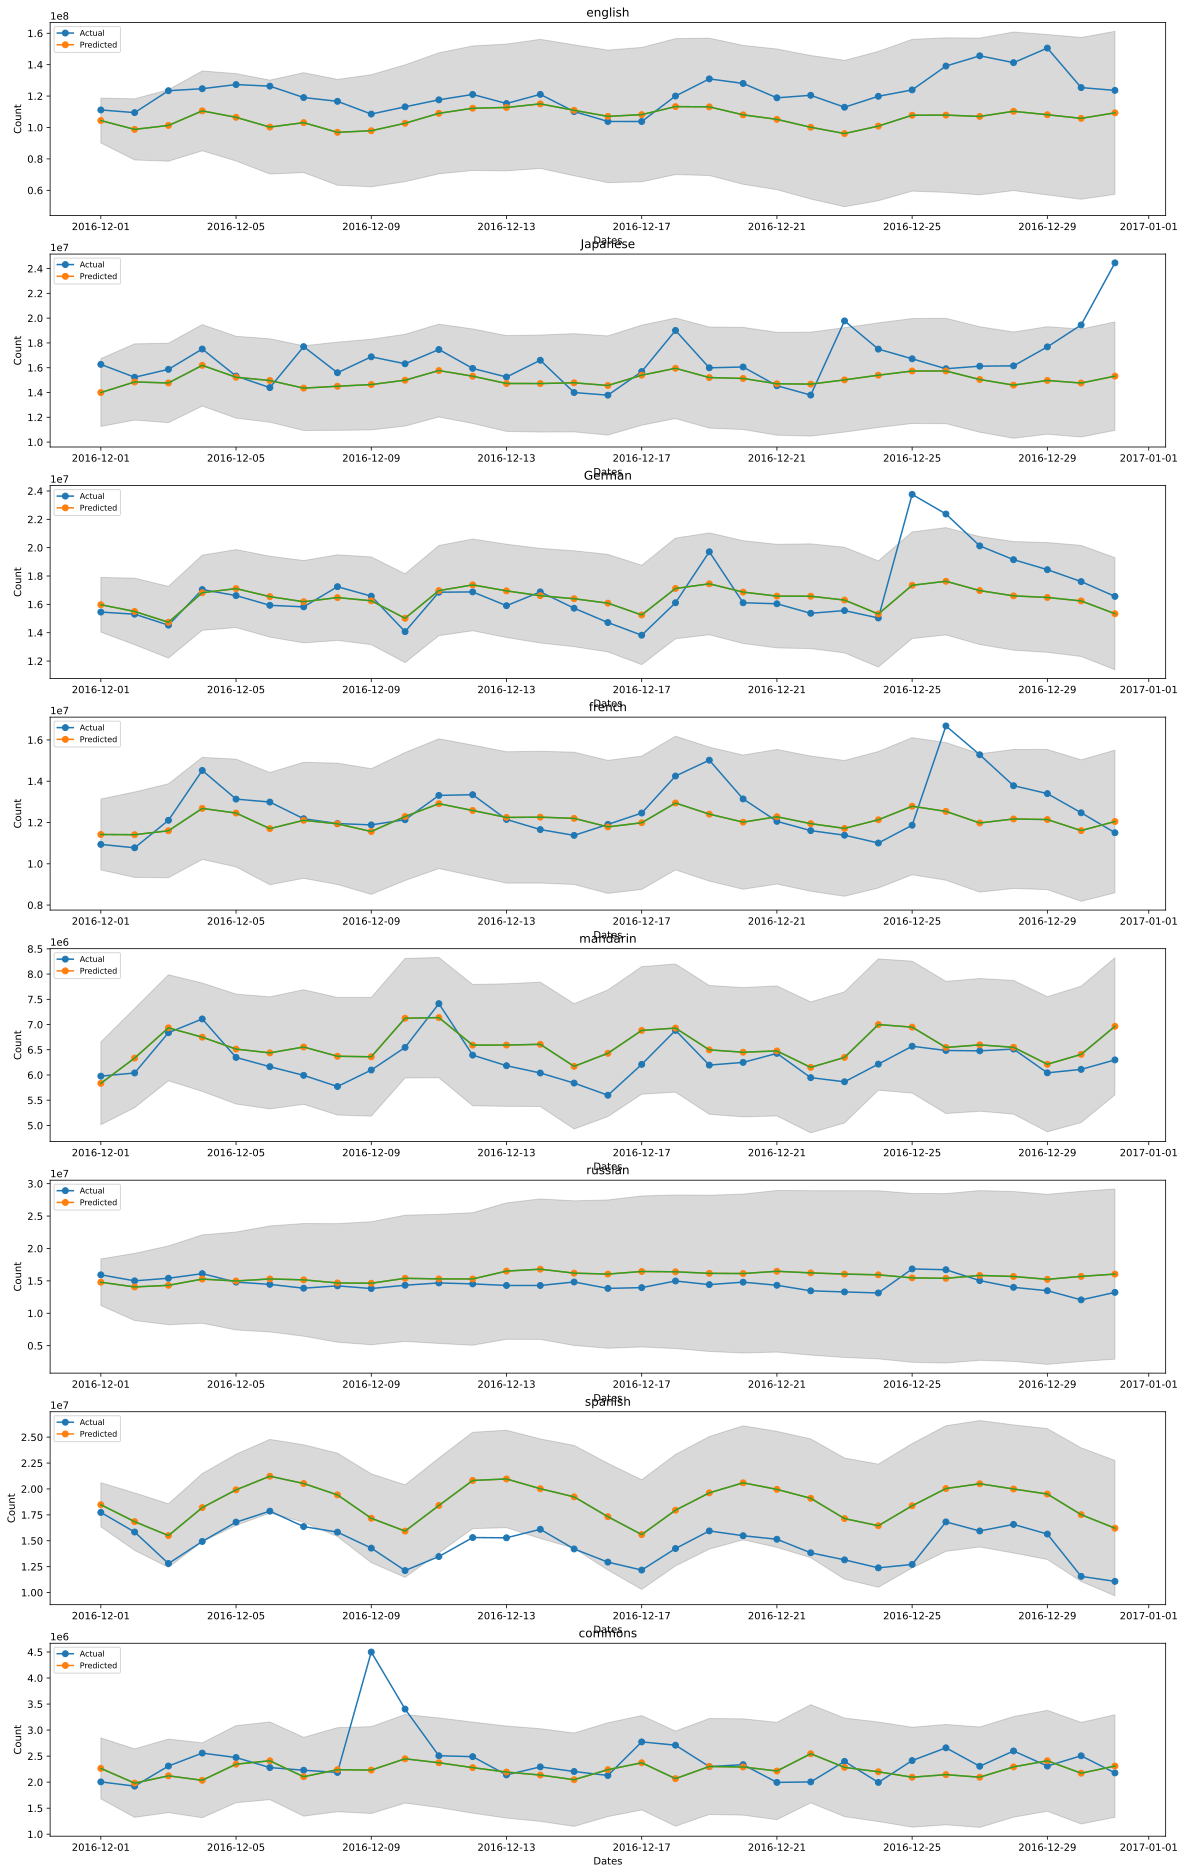

In [179]:

# Create a figure with 8 subplots in a column
fig, axs = plt.subplots(8, 1)
x=ts.index
for i in range(min(len(languages), 8)):
    s=languages[i]
    
    #training
    model = SARIMAX(train_arima[s], order=(25, 1, 15)) 
    model = model.fit(disp=False)

    #predict/get_forecast
    test_arima[f'arima_{s}'] = model.forecast(steps=31)
    forecast = model.get_forecast(steps=31)
    predicted_values = forecast.predicted_mean
    conf = forecast.conf_int(alpha=0.05)


    #test_arima[f'stationary_{s}'] = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf.iloc[:, 0], index=test_arima.index)
    upper_series = pd.Series(conf.iloc[:, 1], index=test_arima.index)

    #performance
    print("---------------------------------------------------")
    print("ARIMA Performance of",s)
    performance(test_arima[s], test_arima[f'arima_{s}'])
    print("---------------------------------------------------")

    #plotting
    axs[i].plot(test_arima[s], '-o')
    axs[i].plot(test_arima[f'arima_{s}'], '-o')
    axs[i].set(title=s, xlabel='Dates', ylabel='Count')
    axs[i].legend(['Actual', 'Predicted'],loc='upper left', fontsize=8)
    
    axs[i].plot(predicted_values, label='forecast')
    
    axs[i].fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
    

# Adjust the spacing between subplots
plt.subplots_adjust(top=5,bottom=0.8)

- We can see the predictions is not upto the mark , as we see the plotting , so we need to do hyperparameter tunning using Gridsearch CV
- Clearly we can see, that the seasonality is not covered in the prediction

## Hyperparameter selection - Model tuning

In [180]:
## The BIC: The Bayesian Information Criterion is an index used in Bayesian statistics to 
#choose between two or more models. Models are compared with the Bayesian information criterion by calculating 
#the BIC for each model. The smaller the BIC value, the better the time series model.

plt.rcParams['figure.figsize'] = (20, 6)

import itertools
import statsmodels.api as sm
global params
params = []
global s_params
s_params = []
global pdq 
global pdqs
global ans_df

p = q = d= range(0, 3)
pdq= list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]



p_ = q_ = d_= range(0, 2)
pdq_= list(itertools.product(p_, d_, q_))
pdqs_ = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p_, d_, q_))]


# Define function
def sarimax_gridsearch(ts, modeltype,s):
  # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value


  if modeltype=='sarimax':
    ans = []
    for comb in pdq_:
        for combs in pdqs_:
            try:
              model = SARIMAX(ts, order=comb, seasonal_order=combs)
              model = model.fit(disp=False)
              #predict/get_forecast
              test_sarimax[f'sarimax_{s}'] = model.forecast(steps=31)
              score= round(mape(test_sarimax[s], test_sarimax[f'sarimax_{s}']), 3)
              ans.append([comb, combs, score])
              
              #print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'mape'])
    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['mape'],ascending=True)[0:3]
    params.append(ans_df.iloc[0,0])
    s_params.append(ans_df.iloc[0,1])

  if modeltype=='arima':
    ans = []
    for comb in pdq:
      try:
        model = SARIMAX(ts, order=comb)
        model = model.fit(disp=False)
        test_arima[f'arima_{s}'] = model.forecast(steps=31)
        score= round(mape(test_arima[s], test_arima[f'arima_{s}']), 3)
        ans.append([comb,score])
    
        #print('SARIMAX {} : BIC Calculated ={}'.format(comb, output.bic))
      except:
        continue
    ans_df = pd.DataFrame(ans, columns=['pdq','mape'])
    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['mape'],ascending=True)[0:3]
    #print(ans_df.iloc[0,0])
    params.append(ans_df.iloc[0,0])
    
    
  return ans_df

#https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b

### Pipelins for hyperparameter tuning for different languages

In [181]:
params.clear()
s_params.clear()


x=ts.index
for i in range(min(len(languages), 8)):
    s=languages[i]
    data=train_arima[s]
    print("----------------------------------------------------")
    print(s)
    print(sarimax_gridsearch(data,'arima',s))
    print("----------------------------------------------------")

----------------------------------------------------
english
          pdq   mape
13  (1, 1, 1)  0.064
23  (2, 1, 2)  0.071
14  (1, 1, 2)  0.072
----------------------------------------------------
----------------------------------------------------
Japanese
          pdq   mape
13  (1, 1, 1)  0.097
22  (2, 1, 1)  0.098
14  (1, 1, 2)  0.098
----------------------------------------------------
----------------------------------------------------
German
          pdq   mape
17  (1, 2, 2)  0.078
7   (0, 2, 1)  0.079
16  (1, 2, 1)  0.079
----------------------------------------------------
----------------------------------------------------
french
          pdq   mape
13  (1, 1, 1)  0.075
5   (0, 1, 2)  0.077
26  (2, 2, 2)  0.077
----------------------------------------------------
----------------------------------------------------
mandarin
          pdq   mape
21  (2, 1, 0)  0.045
3   (0, 1, 0)  0.045
4   (0, 1, 1)  0.045
----------------------------------------------------
----------

## Tuned Arima Model 

We have created a pipeline here to fit the Arima model with best hyperparameter order

---------------------------------------------------
ARIMA Performance of english
MAE : 8108013.357
RMSE : 11177919.132
MAPE: 0.064
---------------------------------------------------
---------------------------------------------------
ARIMA Performance of Japanese
MAE : 1748070.362
RMSE : 2486992.638
MAPE: 0.097
---------------------------------------------------
---------------------------------------------------
ARIMA Performance of German
MAE : 1436660.898
RMSE : 2231444.527
MAPE: 0.078
---------------------------------------------------
---------------------------------------------------
ARIMA Performance of french
MAE : 1012235.935
RMSE : 1430000.523
MAPE: 0.075
---------------------------------------------------
---------------------------------------------------
ARIMA Performance of mandarin
MAE : 291073.444
RMSE : 404181.759
MAPE: 0.045
---------------------------------------------------
---------------------------------------------------
ARIMA Performance of russian
MAE : 7798

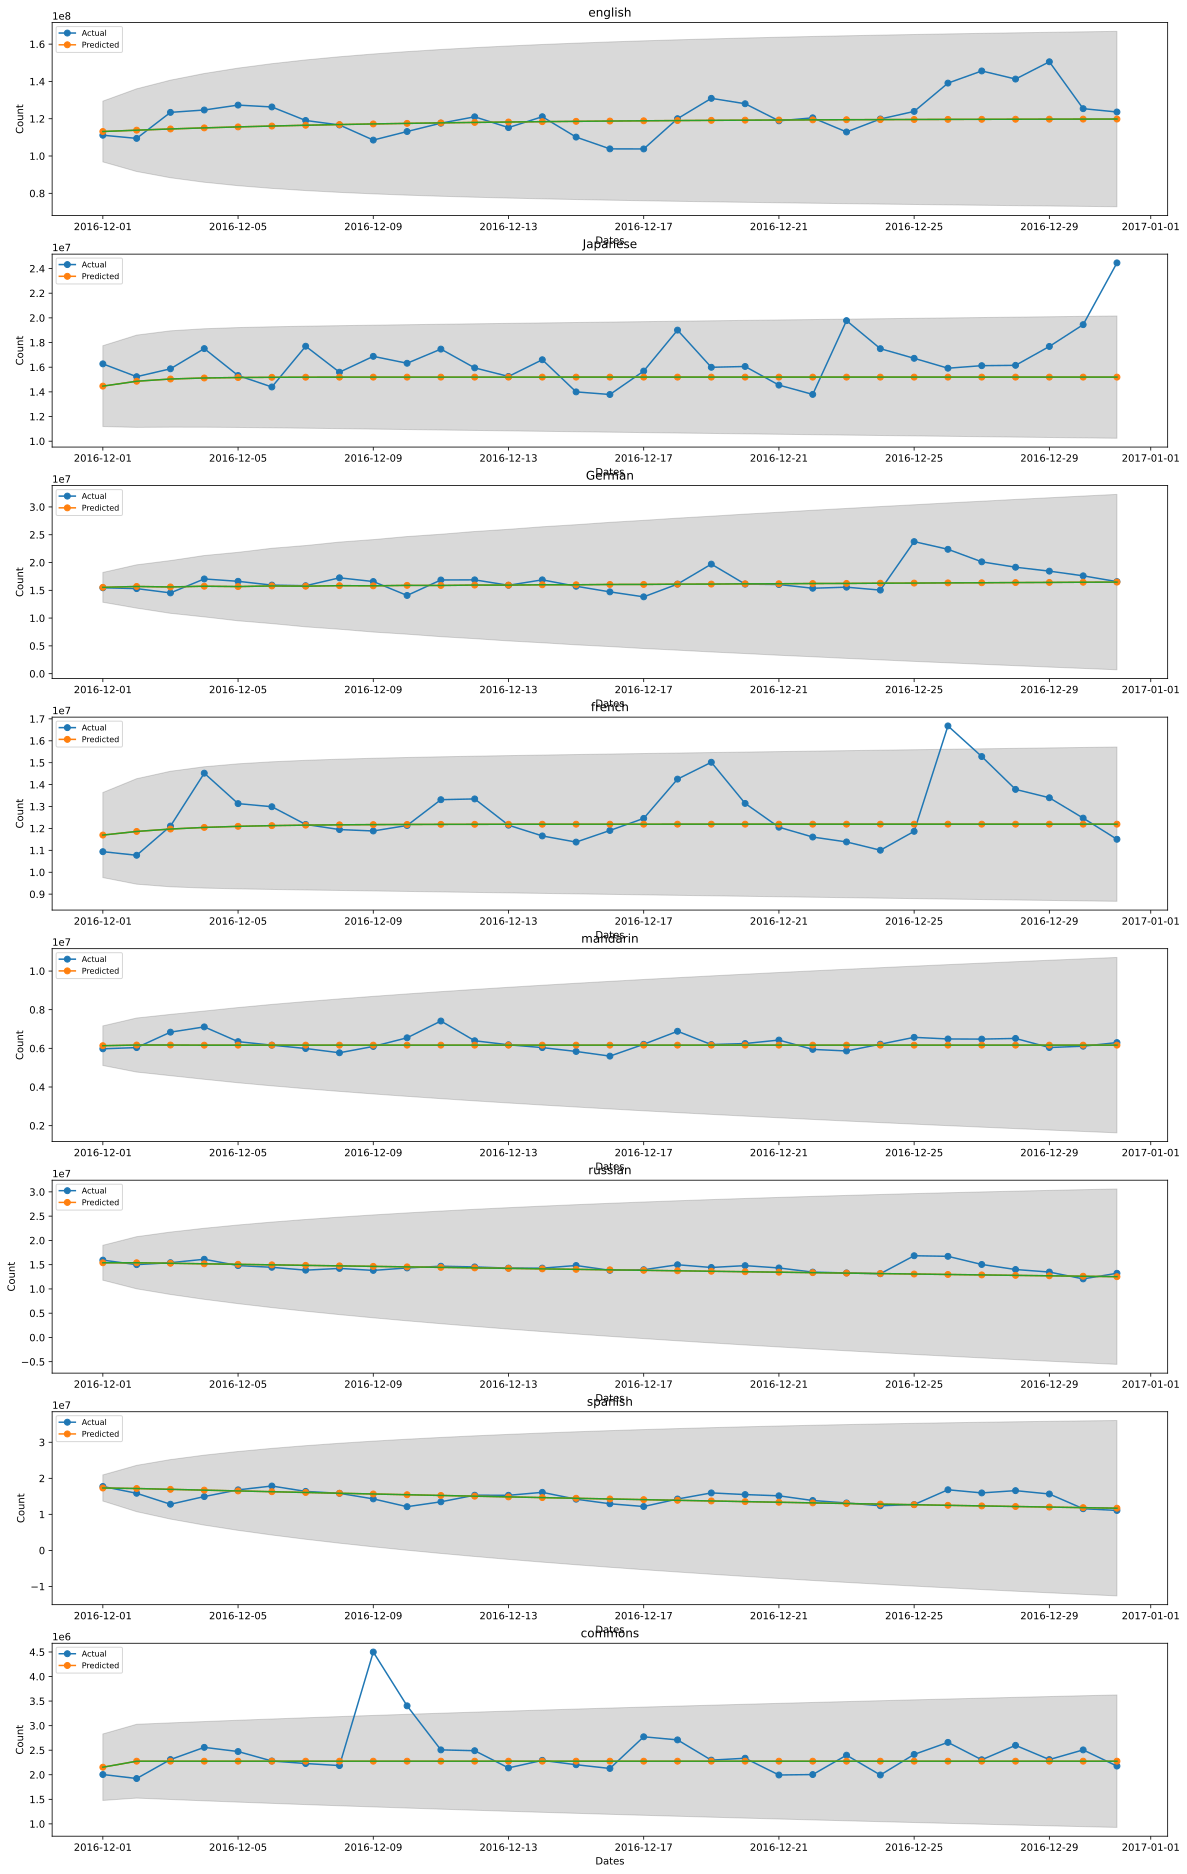

In [182]:
# Create a figure with 8 subplots in a column
fig, axs = plt.subplots(8, 1)
x=ts.index
for i in range(min(len(languages), 8)):
    s=languages[i]
    data=train_arima[s]
    
    #training
    model = SARIMAX(train_arima[s], order=params[i]) 
    model = model.fit(disp=False)

    #predict/get_forecast
    forecast = model.get_forecast(steps=31)
    test_arima[f'arima_{s}'] = model.forecast(steps=31)
    predicted_values = forecast.predicted_mean
    conf = forecast.conf_int(alpha=0.05)


    #test_arima[f'stationary_{s}'] = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf.iloc[:, 0], index=test_arima.index)
    upper_series = pd.Series(conf.iloc[:, 1], index=test_arima.index)

    #performance
    print("---------------------------------------------------")
    print("ARIMA Performance of",s)
    performance(test_arima[s], test_arima[f'arima_{s}'])
    print("---------------------------------------------------")
    
    #plotting
    axs[i].plot(test_arima[s], '-o')
    axs[i].plot(test_arima[f'arima_{s}'], '-o')
    axs[i].set(title=s, xlabel='Dates', ylabel='Count')
    axs[i].legend(['Actual', 'Predicted'],loc='upper left', fontsize=8)
    
    axs[i].plot(predicted_values, label='forecast')
    
    axs[i].fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
    

# Adjust the spacing between subplots
plt.subplots_adjust(top=5,bottom=0.8)

## SARIMA

---------------------------------------------------
SARIMAX Performance of english
MAE : 9816191.023
RMSE : 13232560.369
MAPE: 0.077
---------------------------------------------------
---------------------------------------------------
SARIMAX Performance of Japanese
MAE : 2048831.243
RMSE : 2865492.445
MAPE: 0.114
---------------------------------------------------
---------------------------------------------------
SARIMAX Performance of German
MAE : 1497434.616
RMSE : 2021236.374
MAPE: 0.085
---------------------------------------------------
---------------------------------------------------
SARIMAX Performance of french
MAE : 1207358.04
RMSE : 1672686.977
MAPE: 0.088
---------------------------------------------------
---------------------------------------------------
SARIMAX Performance of mandarin
MAE : 360812.511
RMSE : 431282.875
MAPE: 0.058
---------------------------------------------------
---------------------------------------------------
SARIMAX Performance of russian

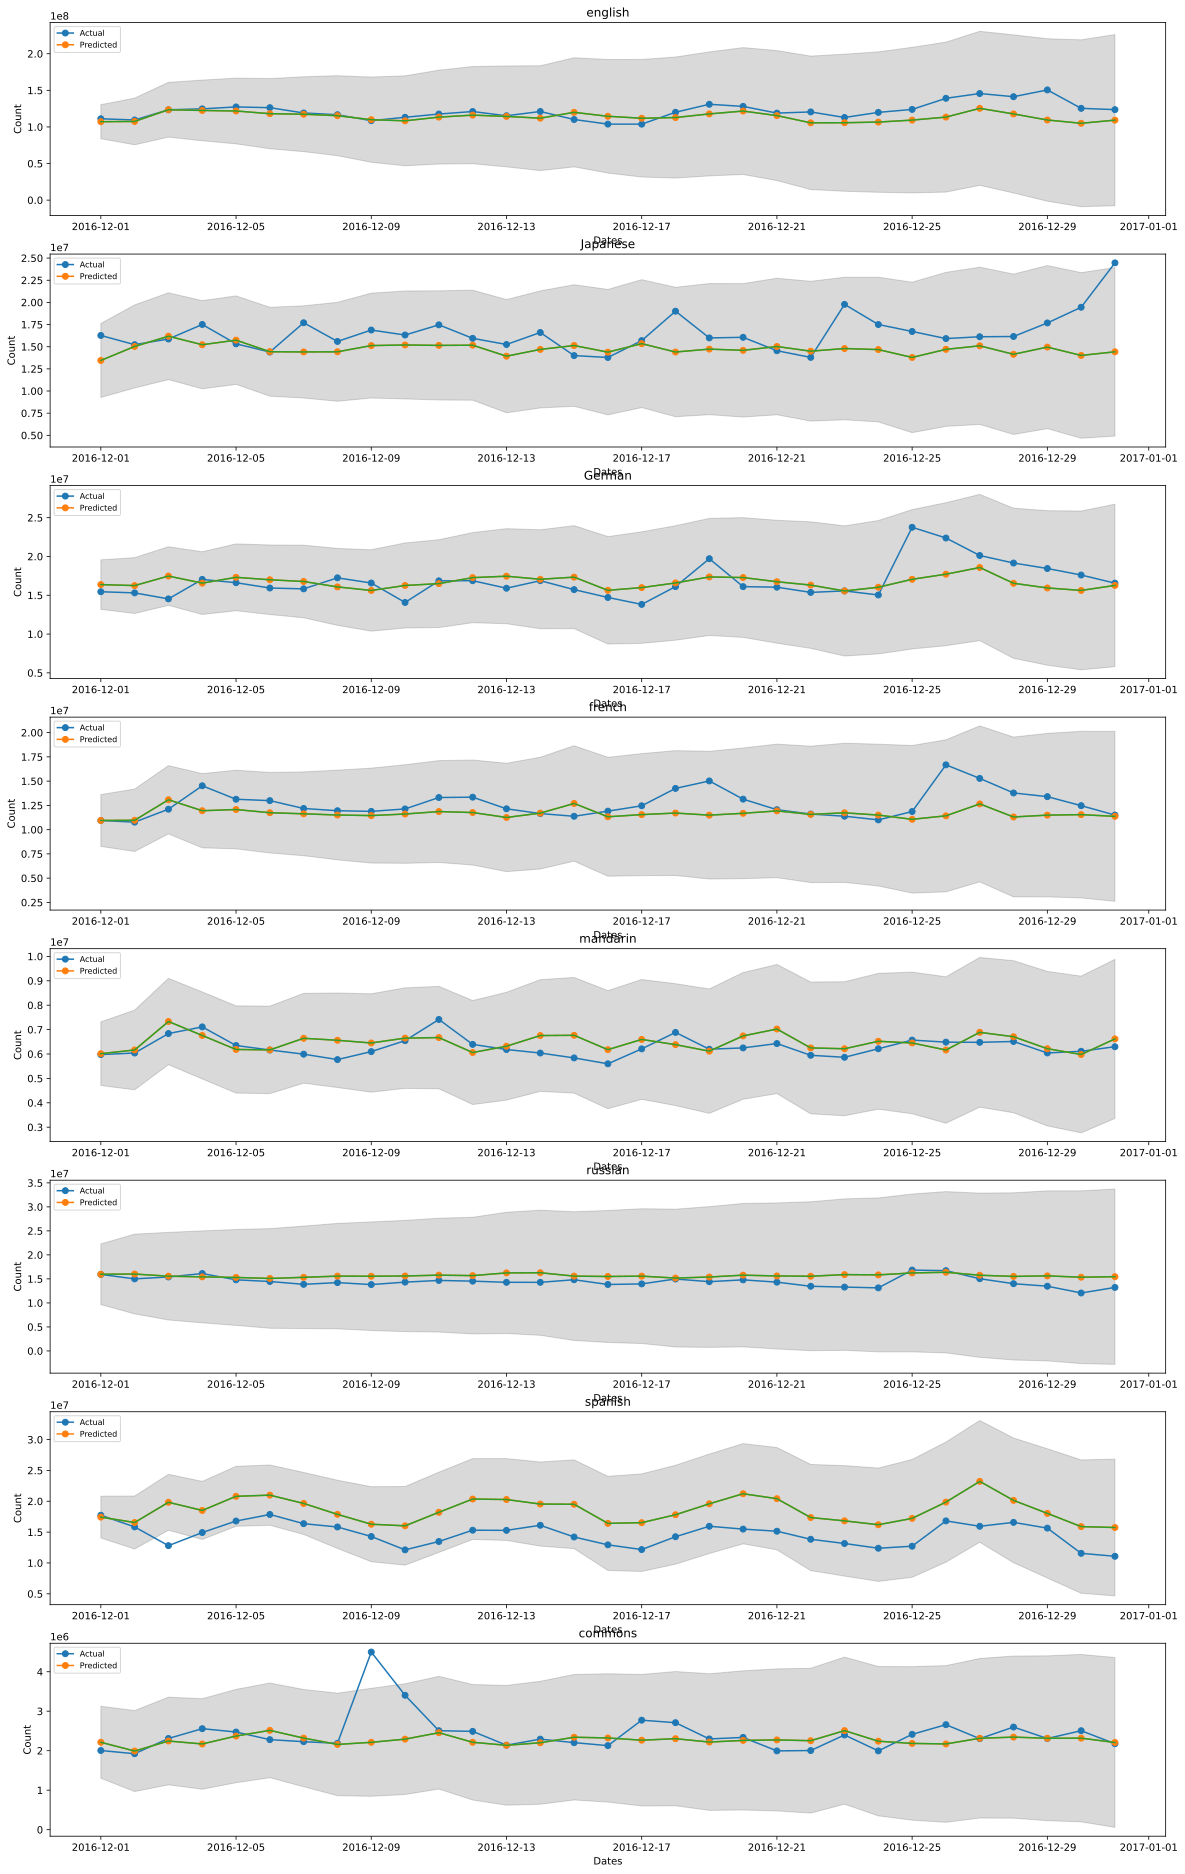

In [183]:

# Create a figure with 8 subplots in a column
fig, axs = plt.subplots(8, 1)
plt.rcParams['figure.figsize'] = (20, 6)
x=ts.index
for i in range(min(len(languages), 8)):
    s=languages[i]
    data=train_sarimax[s]
    
    #training
    model = SARIMAX(train_sarimax[s], order=(5, 1, 3), seasonal_order=(1,1,1,12),enforce_stationarity=False, enforce_invertibility=False) 
    model = model.fit(disp=False)

    #predict/get_forecast
    forecast = model.get_forecast(steps=31)
    test_sarimax[f'sarimax_{s}'] = model.forecast(steps=31)
    predicted_values = forecast.predicted_mean
    conf = forecast.conf_int(alpha=0.05)


    #testX_arima[f'stationary_{s}'] = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf.iloc[:, 0], index=test_sarimax.index)
    upper_series = pd.Series(conf.iloc[:, 1], index=test_sarimax.index)

    #performance
    print("---------------------------------------------------")
    print("SARIMAX Performance of",s)
    performance(test_sarimax[s], test_sarimax[f'sarimax_{s}'])
    print("---------------------------------------------------")
    
    #plotting
    axs[i].plot(test_sarimax[s], '-o')
    axs[i].plot(test_sarimax[f'sarimax_{s}'], '-o')
    axs[i].set(title=s, xlabel='Dates', ylabel='Count')
    axs[i].legend(['Actual', 'Predicted'],loc='upper left', fontsize=8)
    
    axs[i].plot(predicted_values, label='forecast')
    
    axs[i].fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
    

# Adjust the spacing between subplots
plt.subplots_adjust(top=5,bottom=0.8)

## Hypertuning - SARIMA

In [184]:
#sarimax_gridsearch(testX_arima['english'],'sarimax')

In [185]:
#hyperparamter tuning

x=ts.index
params.clear()
s_params.clear()
for i in range(min(len(languages), 8)):
    s=languages[i]
    data=train_sarimax[s]
    print("----------------------------------------------------")
    print(s)
    print(sarimax_gridsearch(data,'sarimax',s))
    print("----------------------------------------------------")

----------------------------------------------------
english
          pdq           pdqs   mape
56  (1, 1, 1)  (0, 0, 0, 12)  0.064
47  (1, 0, 1)  (1, 1, 1, 12)  0.065
39  (1, 0, 0)  (1, 1, 1, 12)  0.066
----------------------------------------------------
----------------------------------------------------
Japanese
          pdq           pdqs   mape
35  (1, 0, 0)  (0, 1, 1, 12)  0.084
43  (1, 0, 1)  (0, 1, 1, 12)  0.084
47  (1, 0, 1)  (1, 1, 1, 12)  0.085
----------------------------------------------------
----------------------------------------------------
German
          pdq           pdqs   mape
53  (1, 1, 0)  (1, 0, 1, 12)  0.079
29  (0, 1, 1)  (1, 0, 1, 12)  0.080
49  (1, 1, 0)  (0, 0, 1, 12)  0.081
----------------------------------------------------
----------------------------------------------------
french
          pdq           pdqs   mape
61  (1, 1, 1)  (1, 0, 1, 12)  0.075
60  (1, 1, 1)  (1, 0, 0, 12)  0.075
56  (1, 1, 1)  (0, 0, 0, 12)  0.075
----------------------

## Tuned SARIMA

We have created a pipeline here to fit the Sarimax model with best hyperparameter order

---------------------------------------------------
SARIMAX Performance of english
MAE : 8108013.357
RMSE : 11177919.132
MAPE: 0.064
---------------------------------------------------
---------------------------------------------------
SARIMAX Performance of Japanese
MAE : 1493275.052
RMSE : 2260594.22
MAPE: 0.084
---------------------------------------------------
---------------------------------------------------
SARIMAX Performance of German
MAE : 1466865.468
RMSE : 2333100.728
MAPE: 0.079
---------------------------------------------------
---------------------------------------------------
SARIMAX Performance of french
MAE : 1028549.681
RMSE : 1496192.678
MAPE: 0.075
---------------------------------------------------
---------------------------------------------------
SARIMAX Performance of mandarin
MAE : 282954.9
RMSE : 407539.501
MAPE: 0.043
---------------------------------------------------
---------------------------------------------------
SARIMAX Performance of russian
M

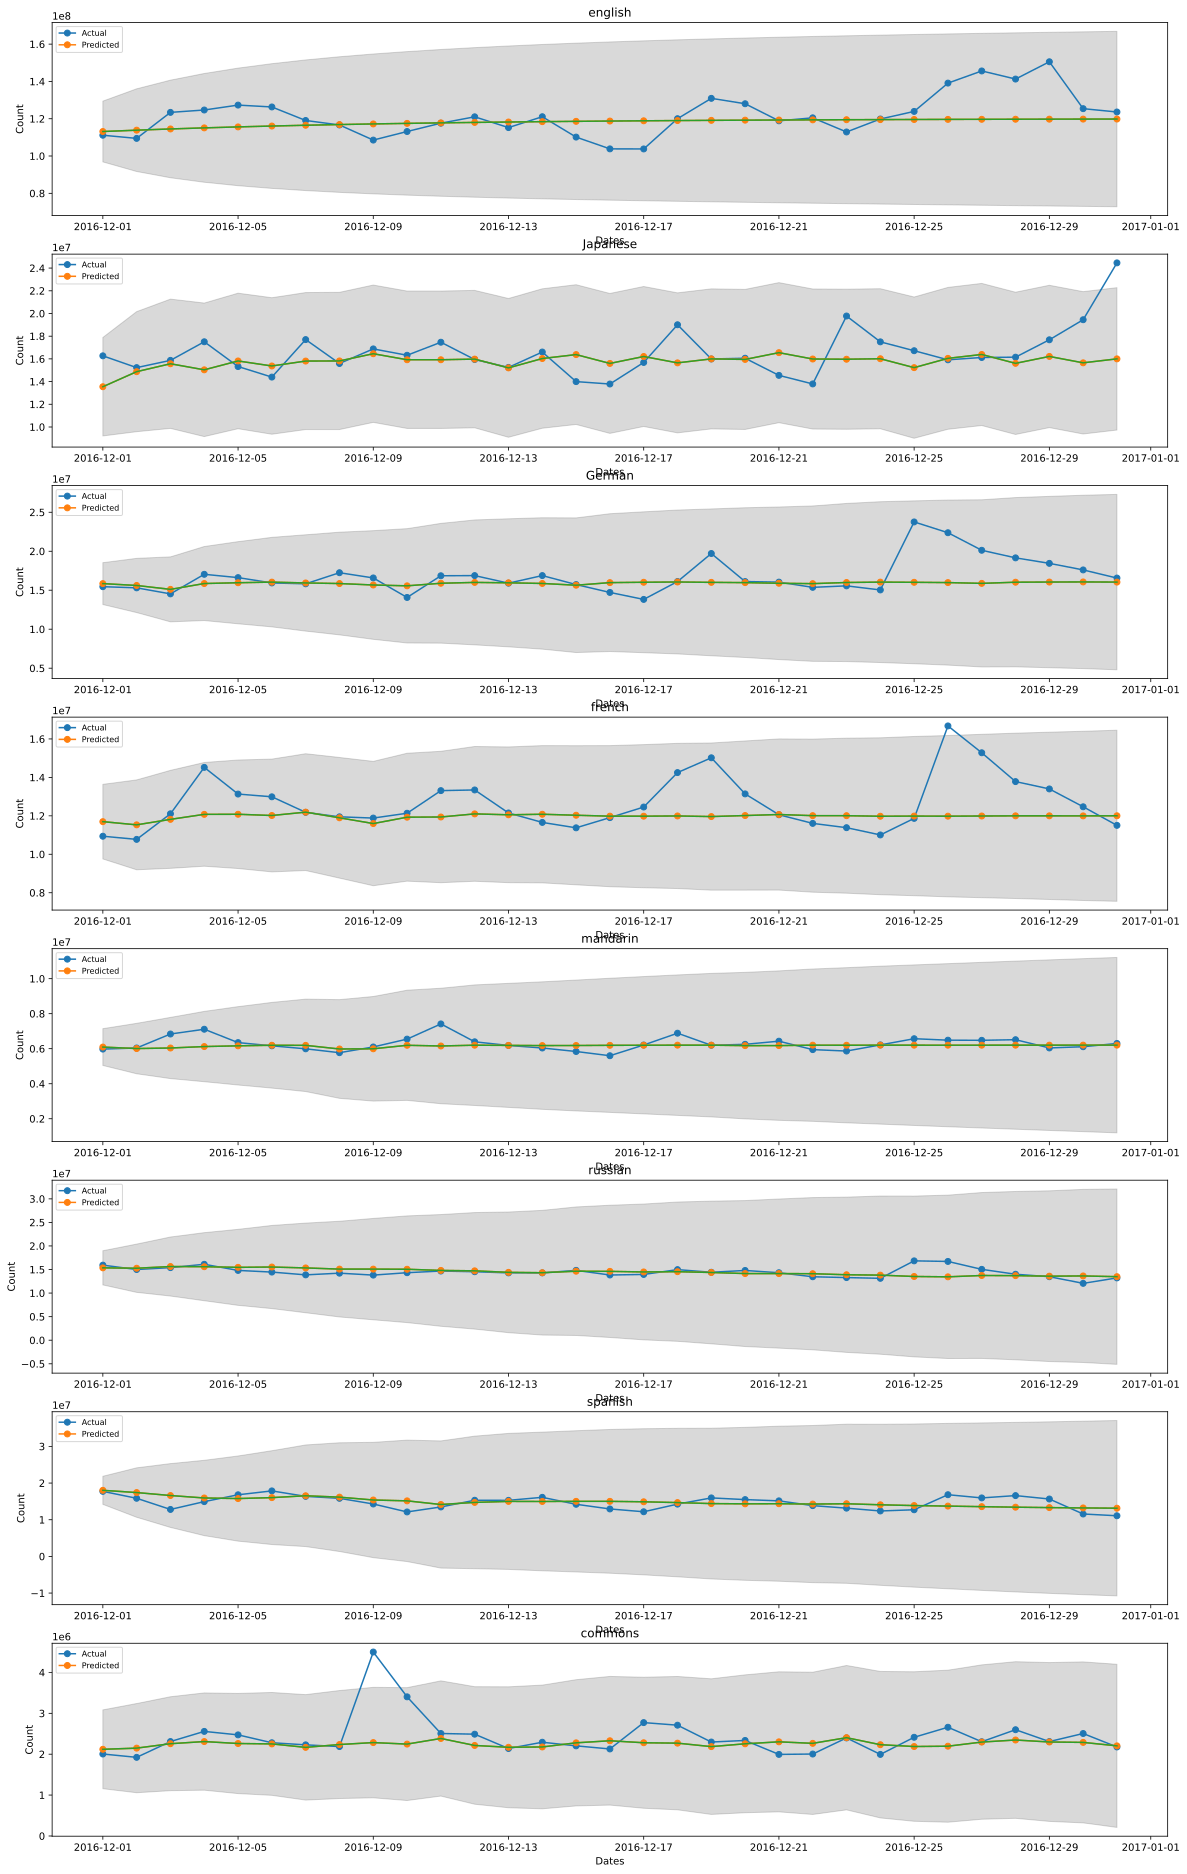

In [186]:

# Create a figure with 8 subplots in a column
fig, axs = plt.subplots(8, 1)
plt.rcParams['figure.figsize'] = (20, 6)
x=ts.index
for i in range(min(len(languages), 8)):
    s=languages[i]
    data=train_sarimax[s]
    
    #training
    model = SARIMAX(train_sarimax[s], order=params[i], seasonal_order=s_params[i]) 
    model = model.fit(disp=False)

    #predict/get_forecast
    forecast = model.get_forecast(steps=31)
    test_sarimax[f'sarimax_{s}'] = model.forecast(steps=31)
    predicted_values = forecast.predicted_mean
    conf = forecast.conf_int(alpha=0.05)


    #testX_arima[f'stationary_{s}'] = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf.iloc[:, 0], index=test_sarimax.index)
    upper_series = pd.Series(conf.iloc[:, 1], index=test_sarimax.index)

    #performance
    print("---------------------------------------------------")
    print("SARIMAX Performance of",s)
    performance(test_sarimax[s], test_sarimax[f'sarimax_{s}'])
    print("---------------------------------------------------")
    
    #plotting
    axs[i].plot(test_sarimax[s], '-o')
    axs[i].plot(test_sarimax[f'sarimax_{s}'], '-o')
    axs[i].set(title=s, xlabel='Dates', ylabel='Count')
    axs[i].legend(['Actual', 'Predicted'],loc='upper left', fontsize=8)
    
    axs[i].plot(predicted_values, label='forecast')
    
    axs[i].fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
    

# Adjust the spacing between subplots
plt.subplots_adjust(top=5,bottom=0.8)

## Sarimax with Exogenous data only for English

Since we have exogenous data only for english , we ll use those data for our sarimax model

In [187]:
# predictions with some in-samples
start=len(train_sarimax)
end=len(train_sarimax)+len(test_sarimax)-1

In [188]:
model = SARIMAX(train_sarimax['english'], exog=train_exog['Exog'], order=(2,1,2),seasonal_order=(1,0,1,7))
results = model.fit(disp=False)


exog_forecast = test_exog[['Exog']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

MAE : 9054524.733
RMSE : 10644328.671
MAPE: 0.072


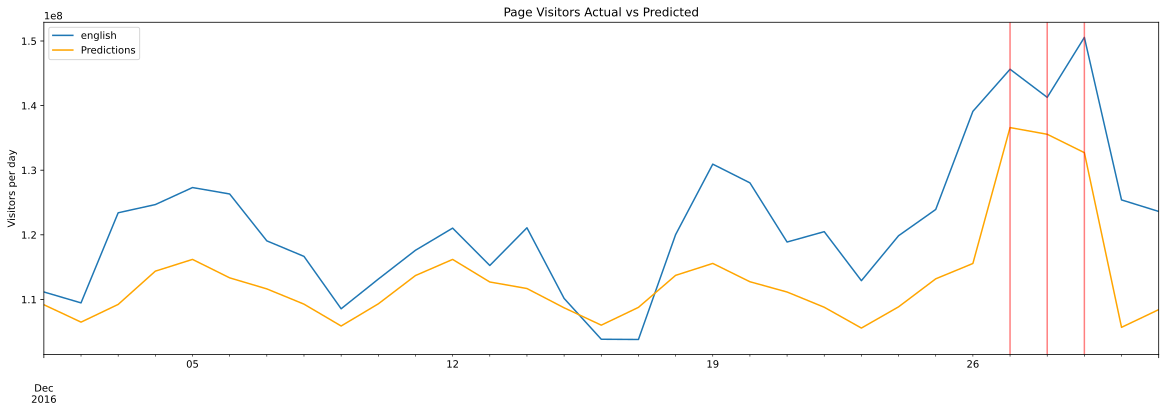

In [189]:
performance(test_sarimax['english'], predictions)
# Plot predictions against known values
title='Page Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test_sarimax['english'].plot(legend=True,figsize=(20,6),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test_exog.query('Exog==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5);

In [190]:
test_sarimax[['lower', 'upper']] = results.get_forecast(steps=31, exog=exog_forecast).conf_int(alpha=0.05).values
test_sarimax['pred'] = results.predict(steps=31, exog=exog_forecast).values[-31:]

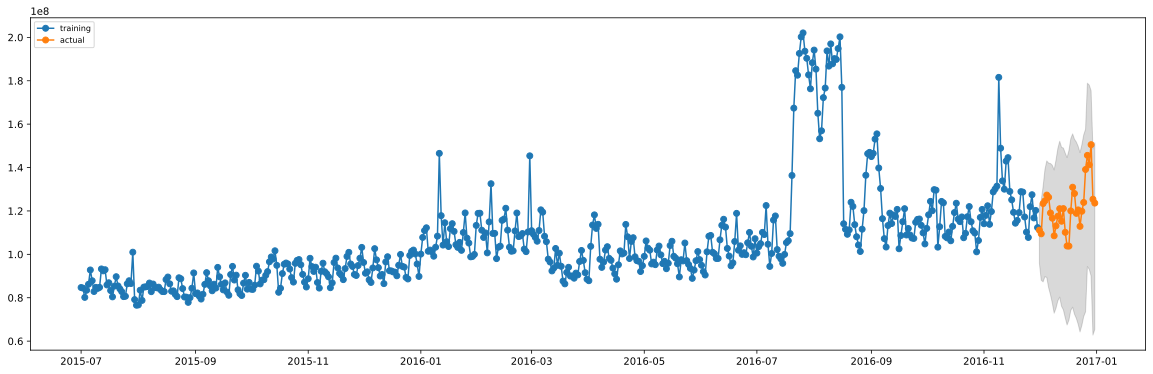

In [191]:
plt.plot(train_sarimax['english'], '-o', label='training')
plt.plot(test_sarimax['english'], '-o', label='actual')
# plt.plot(test['pred'], '-o', label='prediction')
plt.fill_between(test_sarimax.index, test_sarimax['lower'], test_sarimax['upper'], color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Facebook Prophet

In [192]:
! pip install pystan~=2.14
! pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [193]:
# Required !!

# df[['ds','y', 'extra1', 'extra2']]

train_prophet['ds'] = train_prophet.index
train_prophet['y'] = train_prophet['english']

In [194]:
x=train_prophet.merge(train_exog,left_on="Date",right_on="Date",how="left")
x = x[['ds', 'y', 'Exog']]
x.head()

,ds,y,Exog
Date,,,
2015-07-01,2015-07-01,84712023.0,0
2015-07-02,2015-07-02,84438316.0,0
2015-07-03,2015-07-03,80167538.0,0
2015-07-04,2015-07-04,83463039.0,0
2015-07-05,2015-07-05,86198403.0,0


In [195]:
x.tail()

,ds,y,Exog
Date,,,
2016-11-26,2016-11-26,121986637.0,0
2016-11-27,2016-11-27,127488801.0,0
2016-11-28,2016-11-28,116788678.0,0
2016-11-29,2016-11-29,120241275.0,0
2016-11-30,2016-11-30,112336911.0,0


In [196]:
from fbprophet import Prophet

m = Prophet()
m.fit(x[['ds', 'y']][:-31])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [197]:
future = m.make_future_dataframe(periods=31, freq="D")
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01,8.246395e+07,6.002410e+07,1.028506e+08,8.246395e+07,8.246395e+07,-5.616676e+05,-5.616676e+05,-5.616676e+05,-5.616676e+05,-5.616676e+05,-5.616676e+05,0.0,0.0,0.0,8.190228e+07
1,2015-07-02,8.254719e+07,6.056419e+07,1.009512e+08,8.254719e+07,8.254719e+07,-2.817992e+06,-2.817992e+06,-2.817992e+06,-2.817992e+06,-2.817992e+06,-2.817992e+06,0.0,0.0,0.0,7.972920e+07
2,2015-07-03,8.263043e+07,5.625739e+07,9.678947e+07,8.263043e+07,8.263043e+07,-5.531022e+06,-5.531022e+06,-5.531022e+06,-5.531022e+06,-5.531022e+06,-5.531022e+06,0.0,0.0,0.0,7.709941e+07
3,2015-07-04,8.271367e+07,5.755159e+07,1.005134e+08,8.271367e+07,8.271367e+07,-3.715305e+06,-3.715305e+06,-3.715305e+06,-3.715305e+06,-3.715305e+06,-3.715305e+06,0.0,0.0,0.0,7.899837e+07
4,2015-07-05,8.279691e+07,6.357936e+07,1.072638e+08,8.279691e+07,8.279691e+07,3.187523e+06,3.187523e+06,3.187523e+06,3.187523e+06,3.187523e+06,3.187523e+06,0.0,0.0,0.0,8.598444e+07


In [198]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
514,2016-11-26,1.160607e+08,9.166394e+07,1.323306e+08,1.152637e+08,1.167869e+08,-3.715305e+06,-3.715305e+06,-3.715305e+06,-3.715305e+06,-3.715305e+06,-3.715305e+06,0.0,0.0,0.0,1.123454e+08
515,2016-11-27,1.159402e+08,9.860371e+07,1.400161e+08,1.151013e+08,1.167234e+08,3.187523e+06,3.187523e+06,3.187523e+06,3.187523e+06,3.187523e+06,3.187523e+06,0.0,0.0,0.0,1.191277e+08
516,2016-11-28,1.158197e+08,1.025997e+08,1.433779e+08,1.149342e+08,1.166669e+08,7.794038e+06,7.794038e+06,7.794038e+06,7.794038e+06,7.794038e+06,7.794038e+06,0.0,0.0,0.0,1.236137e+08
517,2016-11-29,1.156991e+08,9.510724e+07,1.369276e+08,1.147676e+08,1.166085e+08,1.644425e+06,1.644425e+06,1.644425e+06,1.644425e+06,1.644425e+06,1.644425e+06,0.0,0.0,0.0,1.173436e+08
518,2016-11-30,1.155786e+08,9.551790e+07,1.365404e+08,1.145991e+08,1.165327e+08,-5.616676e+05,-5.616676e+05,-5.616676e+05,-5.616676e+05,-5.616676e+05,-5.616676e+05,0.0,0.0,0.0,1.150169e+08


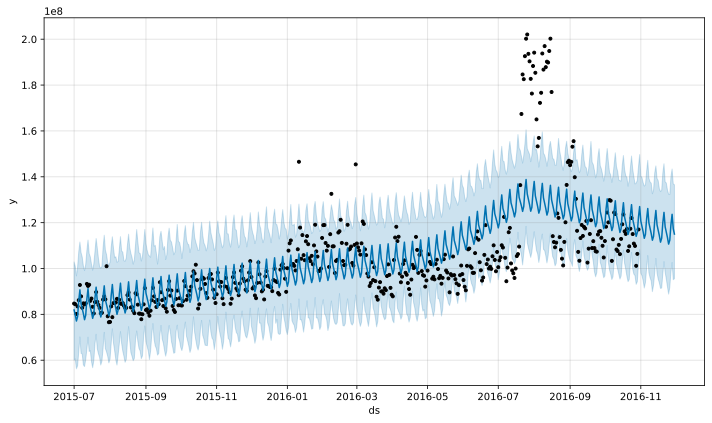

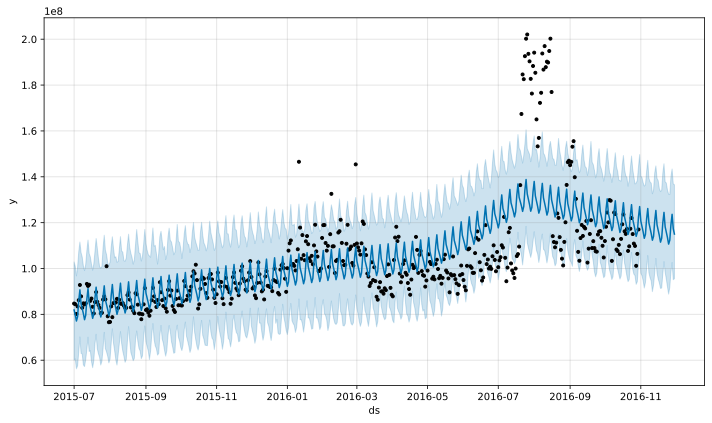

In [199]:
plt.rcParams['figure.figsize'] = (20, 6)
m.plot(forecast)

<Axes: >

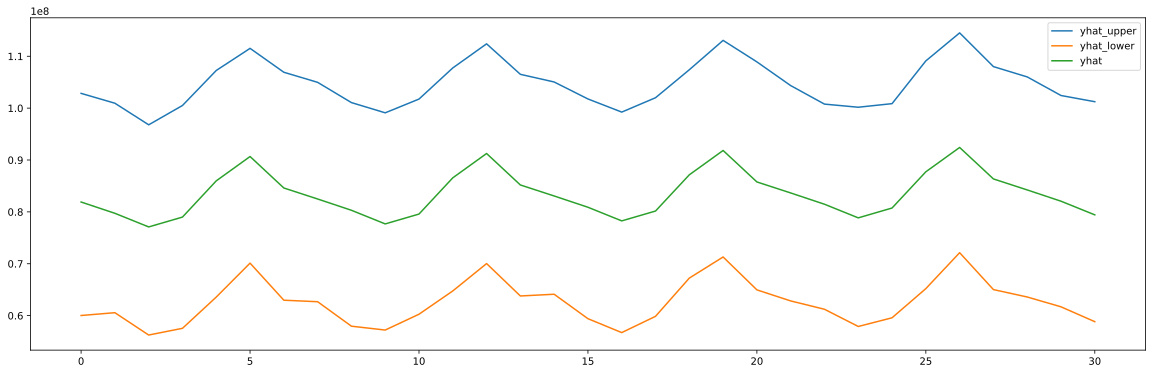

In [200]:
plt.rcParams['figure.figsize'] = (20, 6)
forecast['yhat_upper'][:31].plot(legend=True)
forecast['yhat_lower'][:31].plot(legend=True)
forecast['yhat'][:31].plot(legend=True)

In [201]:
performance(x['y'][:-31], forecast['yhat'][:-31])


MAE : 10505339.084
RMSE : 16473075.401
MAPE: 0.089


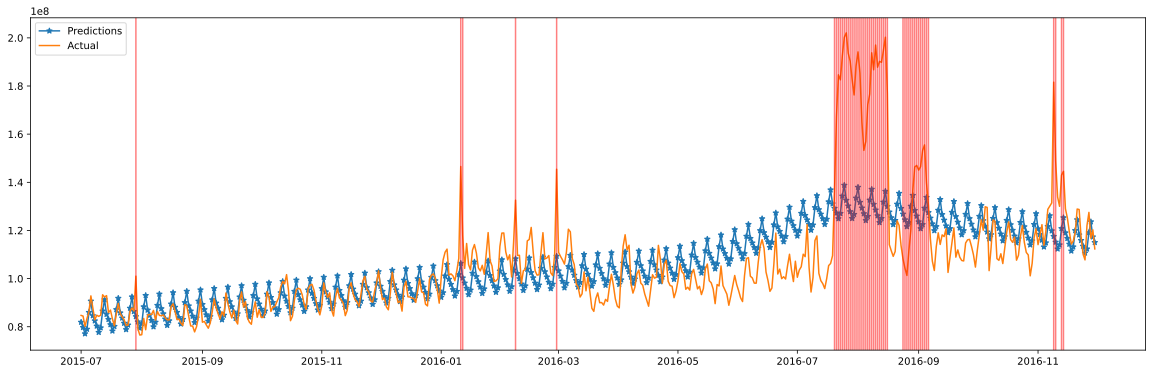

In [202]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.plot(forecast['ds'], forecast['yhat'],'-*', label = 'Predictions')
plt.plot(x['ds'], x['y'], label = 'Actual')

for f in x.query('Exog==1')['ds']: 
    plt.axvline(x=f, color='red', alpha = 0.5);

plt.legend()

## Prophet with EXOG

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


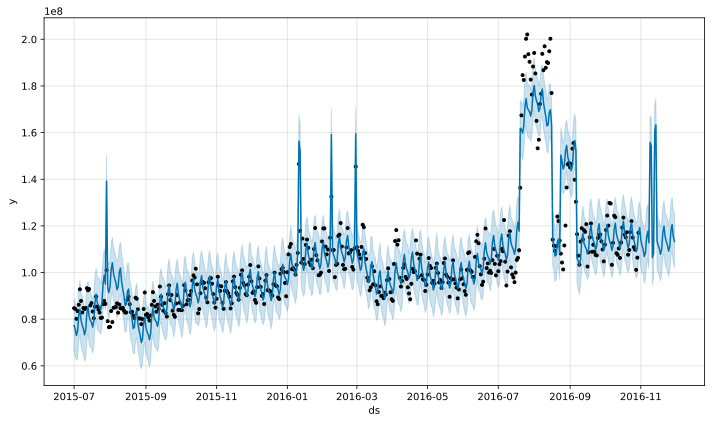

In [203]:
plt.rcParams['figure.figsize'] = (20, 6)
model2 = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model2.add_regressor('Exog') #adding holidays data in the model3
model2.fit(x[:-31])
forecast2 = model2.predict(x)
fig = model2.plot(forecast2)

In [204]:
performance(x['y'][:-39],forecast2['yhat'][:-39])

MAE : 5756700.414
RMSE : 8906409.351
MAPE: 0.053


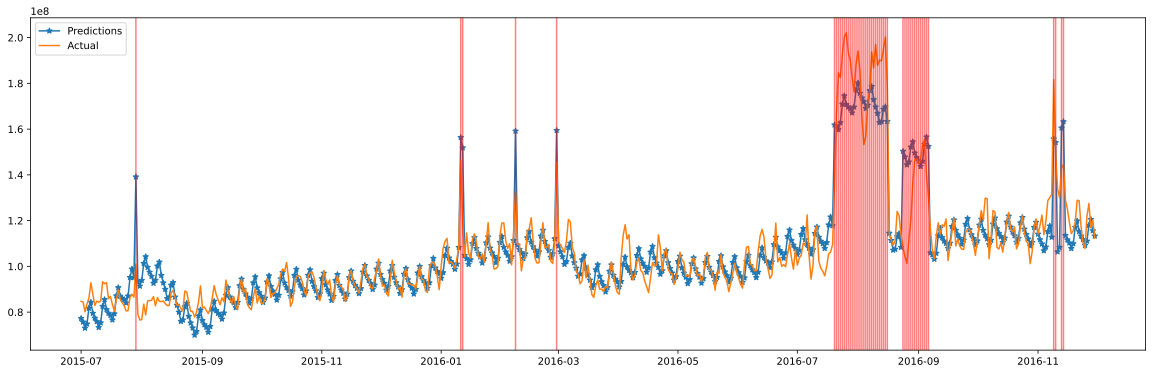

In [205]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.plot(forecast2['ds'], forecast2['yhat'],'-*', label = 'Predictions')
plt.plot(x['ds'], x['y'], label = 'Actual')
for m in x.query('Exog==1')['ds']:
    plt.axvline(x=m, color='red', alpha = 0.5);
plt.legend()

# Observations

- We have 550 time series date present in the data
- The columns we were able to extract are, page, languages, access_type, request_origin,domain,page_name
- We have 7 language , and 1 commons
- We can see, all-access access type are more in dataset
- Mobile and desktop are almost equal in access_type count
- We have English language websites high in count , and second highest is Japanese, third highest is German
- Also we have wikipedia domain is high in count
- We can clearly see , the spider request_origin has only all-access type
- And Commons language type is only seen in wikimdia 
- We have Mandarin in high count in all-access access type
- In time series , we can see some seasonality with little trend
- Also only Russian and Spanish time series are stationary, so we did decomposition /differencing to make time series data stationary
- Also we plotted ACF and PACF , to know which model is suitable AR or MA
- When the data is plotted in arima , we got made of range 4-9%
- So , after hyper parameter tuning , we not able to achieve the desired range in arima
-  In Sarimax,  we got to get 5-9% of male score. After hyper parameter tuning , we are able to get around 4-7% for all languages. Which is a good score compared to arima

# Recommendations

- We build different models like arima, sarimax , sarimax with Exog, prophet, prophet with exog
- We can see, that the sarimax with hyper tuned model, gave good maps score of 4-7% in average for all languages
- We also built a pipeline to build , forecast for different languages
- And also built a pipeline function to hypertune arima and sarimax models
- With Exxon data , we were able to get score of 7% for sarimax with exog for English language
- Prophet model , does not forecast well compared to sarimax
- We should consider , trends and seasonality for all models. And also we should try to predict exog values , if possible using any models
- Also we also should consider other metrics like BIC ,AIC etc with MAPE
- And we also need to do hyper parameter tuning , But hyper parameter tuning with large numbers takes more time . And requires large ram/gpu for faster execution